In [2]:
#importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.utils import shuffle
#sns.set(rc = {'figure.figsize':(16,9)})
random_state = 12345
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from lifelines import CoxPHFitter

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import  learning_curve, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In this file, I want to 
1. handeling the categorical data by getdumi, then I need to convert false and True to 0 and 1\
2. taking the last raadot of every vehicle, I can later use just a random readout
2. merging all three files
3. handeling the missing values by ffilna
now we need to do feature enginering, 
thoese corrolated with each other with threashold 0.95
those not corrolated with RUL less than 0.01
should be removed,

 then the whole vehicles goes for RSF training
 CPH 
 and XGB
 cross validation
 
then by rsf feature importance 30 features would be taken
again rsf with this 30 features and a subset of vehicls
now we run SHAP and survSHAP



In [3]:
# Read train data
X_train = pd.read_csv("IDA_2024/train_operational_readouts.csv")
X_train_spec = pd.read_csv("IDA_2024/train_specifications.csv")
X_train_tte = pd.read_csv("IDA_2024/train_tte.csv")


In [4]:
spec_encoded = pd.get_dummies(X_train_spec)

In [5]:
spec_encoded = spec_encoded.replace({False: 0, True: 1}) 

C:\Users\moka6903\AppData\Local\Temp\5\ipykernel_7524\3087576332.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  spec_encoded = spec_encoded.replace({False: 0, True: 1})


In [6]:
categorical_col = spec_encoded.columns[1:]
numerical_col = X_train.columns[2:]
#list(numerical_col)

#using last read out

In [7]:
# Select maximum cycle
max_cycle = X_train.groupby(by="vehicle_id")['time_step'].transform(max)
X_train_max_cycle = X_train[X_train["time_step"] == max_cycle].reset_index()


X_train_max_cycle.drop(columns='index', axis = 1, inplace= True)
X_train_max_cycle

C:\Users\moka6903\AppData\Local\Temp\5\ipykernel_7524\1292955176.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  max_cycle = X_train.groupby(by="vehicle_id")['time_step'].transform(max)


vehicle_id  time_step       171_0     666_0        427_0     837_0  \
0               0      507.4  10189950.0  372685.0          NaN   41670.0   
1               2      281.0   5648790.0  289371.0  233978571.0   68717.0   
2               3      291.2   7603590.0  230831.0  273813365.0  100121.0   
3               4      203.0   4842780.0  210381.0  174662976.0  152385.0   
4               5      357.6   6623040.0  280531.0  246994778.0  164673.0   
...           ...        ...         ...       ...          ...       ...   
23545       33639      112.6   2894100.0   75859.0   98975802.0   10040.0   
23546       33640      123.2   3925455.0  138179.0  139017335.0   35726.0   
23547       33641      116.0   2567085.0  118371.0   91726867.0    9122.0   
23548       33642      126.4   3350700.0   80078.0  118733863.0   11251.0   
23549       33643      125.8   2741460.0   52949.0  104122894.0   15222.0   

         167_0      167_1       167_2       167_3  ...     397_26     397_27  \
0          NaN        NaN         NaN         NaN  ...  3929234.0   244761.0   
1      10415.0  9137870.0  74655621.0  45991626.0  ...  2448559.0   158719.0   
2       5918.0  8225139.0  17004223.0  10504195.0  ...  3352945.0   257213.0   
3       7128.0  4342398.0  13348382.0  11538870.0  ...  1210855.0  1597067.0   
4          NaN        NaN         NaN         NaN  ...  1930796.0  1258478.0   
...        ...        ...         ...         ...  ...        ...        ...   
23545   6631.0  5229663.0  10519563.0   8797533.0  ...  1144796.0    57072.0   
23546  15397.0  5757292.0  11640261.0   7568543.0  ...  2084221.0   146938.0   
23547   6783.0  3383972.0   6551850.0   6232055.0  ...  1155147.0    66576.0   
23548    755.0  9392926.0  16152271.0   7956861.0  ...  1439029.0    67591.0   
23549    843.0  7988418.0  16274631.0   8095988.0  ...   936034.0    45137.0   

         397_28  397_29   397_30     397_31     397_32     397_33    397_34  \
0       43934.0   367.0  36431.0  3534852.0  4290245.0  1027186.0  138939.0   
1       23655.0   246.0  18151.0  1193941.0  1680728.0   328910.0   57511.0   
2       29928.0   204.0   7952.0   719693.0  2648967.0   531790.0   76915.0   
3       46286.0   742.0  10529.0   370756.0  1651890.0  1282530.0  453350.0   
4      203666.0  2601.0   9754.0   465567.0  1684524.0   979654.0  515597.0   
...         ...     ...      ...        ...        ...        ...       ...   
23545   28718.0   156.0   7958.0   239587.0  1024221.0   384568.0  101945.0   
23546   97421.0   556.0  26526.0   409625.0  1390447.0   474318.0  338311.0   
23547   11585.0   100.0  25511.0   796852.0  1395692.0   264116.0   33488.0   
23548    9768.0    80.0  16320.0   910530.0  1851490.0   290285.0   41111.0   
23549    8493.0    48.0  23484.0   801725.0   814410.0   128663.0   23453.0   

       397_35  
0       792.0  
1       793.0  
2       712.0  
3      1962.0  
4      8663.0  
...       ...  
23545   401.0  
23546  5127.0  
23547   222.0  
23548   536.0  
23549    32.0  

[23550 rows x 107 columns]

Merging three datasets

In [8]:
# Here I merged validation train and validation lable
# and merged train and its lable 
df_train = pd.merge(X_train_tte , X_train_max_cycle , left_on='vehicle_id', right_on='vehicle_id')
dataset_merged=  pd.merge(df_train, spec_encoded , left_on='vehicle_id', right_on='vehicle_id')

dataset_merged.isna().sum().sum()

11675

Missing value is filled with their above row value by ffill

In [9]:
dataset_ffil = dataset_merged.bfill(axis = 0)
dataset_ffil.isna().sum().sum()

0

In [10]:
# Create status column

dataset_ffil['status'] = dataset_ffil['in_study_repair'].apply(lambda x: False if x == 0 else True)

# Distribution of each status
print('X_train value_counts',dataset_ffil['status'].value_counts())

X_train value_counts status
False    21278
True      2272
Name: count, dtype: int64


In [11]:
dataset_ffil['RUL'] = dataset_ffil['length_of_study_time_step'] - dataset_ffil['time_step']

In [12]:
dataset_ffil

vehicle_id  length_of_study_time_step  in_study_repair  time_step  \
0               0                      510.0                0      507.4   
1               2                      281.8                0      281.0   
2               3                      293.4                0      291.2   
3               4                      210.0                0      203.0   
4               5                      360.4                0      357.6   
...           ...                        ...              ...        ...   
23545       33639                      137.4                0      112.6   
23546       33640                      124.6                0      123.2   
23547       33641                      123.0                0      116.0   
23548       33642                      126.6                0      126.4   
23549       33643                      130.2                0      125.8   

            171_0     666_0        427_0     837_0    167_0      167_1  ...  \
0      10189950.0  372685.0  233978571.0   41670.0  10415.0  9137870.0  ...   
1       5648790.0  289371.0  233978571.0   68717.0  10415.0  9137870.0  ...   
2       7603590.0  230831.0  273813365.0  100121.0   5918.0  8225139.0  ...   
3       4842780.0  210381.0  174662976.0  152385.0   7128.0  4342398.0  ...   
4       6623040.0  280531.0  246994778.0  164673.0   2688.0  6438153.0  ...   
...           ...       ...          ...       ...      ...        ...  ...   
23545   2894100.0   75859.0   98975802.0   10040.0   6631.0  5229663.0  ...   
23546   3925455.0  138179.0  139017335.0   35726.0  15397.0  5757292.0  ...   
23547   2567085.0  118371.0   91726867.0    9122.0   6783.0  3383972.0  ...   
23548   3350700.0   80078.0  118733863.0   11251.0    755.0  9392926.0  ...   
23549   2741460.0   52949.0  104122894.0   15222.0    843.0  7988418.0  ...   

       Spec_7_Cat1  Spec_7_Cat2  Spec_7_Cat3  Spec_7_Cat4  Spec_7_Cat5  \
0                0            0            0            0            0   
1                1            0            0            0            0   
2                1            0            0            0            0   
3                1            0            0            0            0   
4                1            0            0            0            0   
...            ...          ...          ...          ...          ...   
23545            0            0            0            1            0   
23546            0            0            0            1            0   
23547            0            0            0            1            0   
23548            0            0            0            1            0   
23549            0            0            0            1            0   

       Spec_7_Cat6  Spec_7_Cat7  Spec_7_Cat8  status   RUL  
0                0            0            0   False   2.6  
1                0            0            0   False   0.8  
2                0            0            0   False   2.2  
3                0            0            0   False   7.0  
4                0            0            0   False   2.8  
...            ...          ...          ...     ...   ...  
23545            0            0            0   False  24.8  
23546            0            0            0   False   1.4  
23547            0            0            0   False   7.0  
23548            0            0            0   False   0.2  
23549            0            0            0   False   4.4  

[23550 rows x 201 columns]

How to find the vehicle id of one specific index, later is needed for local explainability

In [13]:
index_to_lookup = 3000

# Get the Vehicle ID corresponding to the specified index
vehicle_id = dataset_ffil.loc[index_to_lookup, 'vehicle_id']

print(f"Vehicle ID corresponding to index {index_to_lookup}: {vehicle_id}")

Vehicle ID corresponding to index 3000: 4290


In [14]:
target_column = 'RUL'
df = dataset_ffil[list(numerical_col) + list(categorical_col) + ['RUL']].copy()
df['RUL']


0         2.6
1         0.8
2         2.2
3         7.0
4         2.8
         ... 
23545    24.8
23546     1.4
23547     7.0
23548     0.2
23549     4.4
Name: RUL, Length: 23550, dtype: float64

In [15]:

# Assuming df is your dataframe containing the features and target variable
# Compute the correlation matrix
correlation_matrix = df.corrwith(df[target_column]).abs()

# Filter out correlations below the threshold
threshold = 0.01
filtered_correlations = correlation_matrix[correlation_matrix.abs() <= threshold]

# Sort the remaining correlations in ascending order
sorted_correlations = filtered_correlations.sort_values()
least_correlated_features = sorted_correlations.index.tolist()
# Print the least correlated features
print("Least correlated features:")
print(least_correlated_features)


Least correlated features:
['Spec_2_Cat5', 'Spec_7_Cat8', 'Spec_6_Cat10', 'Spec_1_Cat12', 'Spec_1_Cat19', 'Spec_1_Cat16', 'Spec_6_Cat13', 'Spec_2_Cat4', 'Spec_2_Cat13', '291_0', 'Spec_1_Cat24', 'Spec_1_Cat6', 'Spec_3_Cat2', '158_0', 'Spec_1_Cat15', 'Spec_1_Cat18', 'Spec_6_Cat18', 'Spec_2_Cat11', 'Spec_2_Cat15', 'Spec_1_Cat3', '397_23', '397_11', '397_28', '291_7', '397_22', '397_10', '397_29', 'Spec_6_Cat6', '397_9', 'Spec_6_Cat8', 'Spec_2_Cat20', 'Spec_1_Cat25', '397_4', '397_16', 'Spec_1_Cat4', 'Spec_5_Cat2', '291_8', '397_15', '291_9', 'Spec_1_Cat9', '397_21', '291_6', '397_12', 'Spec_1_Cat27', '291_1', '397_17', '459_17', '291_10', '291_2', 'Spec_3_Cat0', 'Spec_0_Cat0', '397_2', 'Spec_2_Cat7', 'Spec_2_Cat12', 'Spec_2_Cat3', 'Spec_1_Cat10', 'Spec_1_Cat23', '397_14', '459_19', 'Spec_6_Cat15', 'Spec_2_Cat18', 'Spec_5_Cat1', '397_7', 'Spec_1_Cat22', '397_3', '397_6', 'Spec_0_Cat1', 'Spec_1_Cat7', 'Spec_2_Cat19', 'Spec_2_Cat6', 'Spec_1_Cat11', '397_19', 'Spec_5_Cat0', 'Spec_5_Cat3', '39

In [16]:

dataset_droped_corr = dataset_ffil.drop(columns= least_correlated_features, inplace = False)
dataset_droped_corr

vehicle_id  length_of_study_time_step  in_study_repair  time_step  \
0               0                      510.0                0      507.4   
1               2                      281.8                0      281.0   
2               3                      293.4                0      291.2   
3               4                      210.0                0      203.0   
4               5                      360.4                0      357.6   
...           ...                        ...              ...        ...   
23545       33639                      137.4                0      112.6   
23546       33640                      124.6                0      123.2   
23547       33641                      123.0                0      116.0   
23548       33642                      126.6                0      126.4   
23549       33643                      130.2                0      125.8   

            171_0     666_0        427_0     837_0    167_0      167_1  ...  \
0      10189950.0  372685.0  233978571.0   41670.0  10415.0  9137870.0  ...   
1       5648790.0  289371.0  233978571.0   68717.0  10415.0  9137870.0  ...   
2       7603590.0  230831.0  273813365.0  100121.0   5918.0  8225139.0  ...   
3       4842780.0  210381.0  174662976.0  152385.0   7128.0  4342398.0  ...   
4       6623040.0  280531.0  246994778.0  164673.0   2688.0  6438153.0  ...   
...           ...       ...          ...       ...      ...        ...  ...   
23545   2894100.0   75859.0   98975802.0   10040.0   6631.0  5229663.0  ...   
23546   3925455.0  138179.0  139017335.0   35726.0  15397.0  5757292.0  ...   
23547   2567085.0  118371.0   91726867.0    9122.0   6783.0  3383972.0  ...   
23548   3350700.0   80078.0  118733863.0   11251.0    755.0  9392926.0  ...   
23549   2741460.0   52949.0  104122894.0   15222.0    843.0  7988418.0  ...   

       Spec_6_Cat9  Spec_7_Cat0  Spec_7_Cat1  Spec_7_Cat2  Spec_7_Cat4  \
0                0            1            0            0            0   
1                0            0            1            0            0   
2                0            0            1            0            0   
3                0            0            1            0            0   
4                0            0            1            0            0   
...            ...          ...          ...          ...          ...   
23545            0            0            0            0            1   
23546            0            0            0            0            1   
23547            0            0            0            0            1   
23548            0            0            0            0            1   
23549            0            0            0            0            1   

       Spec_7_Cat5  Spec_7_Cat6  Spec_7_Cat7  status   RUL  
0                0            0            0   False   2.6  
1                0            0            0   False   0.8  
2                0            0            0   False   2.2  
3                0            0            0   False   7.0  
4                0            0            0   False   2.8  
...            ...          ...          ...     ...   ...  
23545            0            0            0   False  24.8  
23546            0            0            0   False   1.4  
23547            0            0            0   False   7.0  
23548            0            0            0   False   0.2  
23549            0            0            0   False   4.4  

[23550 rows x 108 columns]

we droped the least corrolated features with RUL

In [57]:

df2 = dataset_droped_corr.drop(columns= ['length_of_study_time_step', 'time_step', 'in_study_repair', 'vehicle_id', 'status','RUL'], axis = 1)

# Define the correlation threshold
correlation_threshold = 0.90
correlation_matrix = df2.corr().abs()
# Get the upper triangle of the correlation matrix
upper_triangle = np.triu(correlation_matrix, k=1)

# Find the indices where the correlation exceeds the threshold
high_correlation_indices = np.where(upper_triangle > correlation_threshold)

# Initialize a list to store pairs of highly correlated variables
high_correlation_pairs = []
high_correlation_features = []
high_correlation_features_all = []

# Iterate through the indices and extract the variable pairs
for i, j in zip(high_correlation_indices[0], high_correlation_indices[1]):
    variable_i = correlation_matrix.index[i]
    variable_j = correlation_matrix.columns[j]
    correlation_value = correlation_matrix.iloc[i, j]
    high_correlation_pairs.append((variable_i, variable_j, correlation_value))
    high_correlation_features.append(variable_i)
    high_correlation_features_all.append(variable_i)
    high_correlation_features_all.append(variable_j)

# Print the highly correlated variable pairs
print("Highly Correlated Variable Pairs:")
for pair in high_correlation_pairs:
    print(pair)
print( list(set(high_correlation_features)))

Highly Correlated Variable Pairs:
('171_0', '427_0', 0.9730007497452052)
('171_0', '167_5', 0.9460448609594139)
('171_0', '158_4', 0.9262147919807299)
('427_0', '167_5', 0.9382254164771827)
('427_0', '835_0', 0.9303269247821015)
('427_0', '158_4', 0.9128112793731821)
('167_1', '272_0', 0.9400816811370624)
('167_5', '158_4', 0.9001366810567631)
('835_0', '158_2', 0.9104151987804896)
('291_4', '291_5', 0.932067975608117)
('158_4', '158_5', 0.9117096484768004)
('158_5', '158_6', 0.9705508849684782)
('158_5', '397_20', 0.9027896509711755)
('158_6', '158_7', 0.9097054380177748)
('158_6', '397_26', 0.906111555668511)
('158_8', '397_32', 0.9001561683485353)
('459_2', '459_3', 0.9621184433854746)
('459_2', '459_4', 0.9132452923656494)
('459_3', '459_4', 0.9757330762892937)
('459_3', '459_5', 0.936554709077647)
('459_4', '459_5', 0.9801950466014356)
('459_4', '459_6', 0.9295318585796065)
('459_5', '459_6', 0.9736551689124806)
('459_5', '459_7', 0.920422411187694)
('459_6', '459_7', 0.9708841383

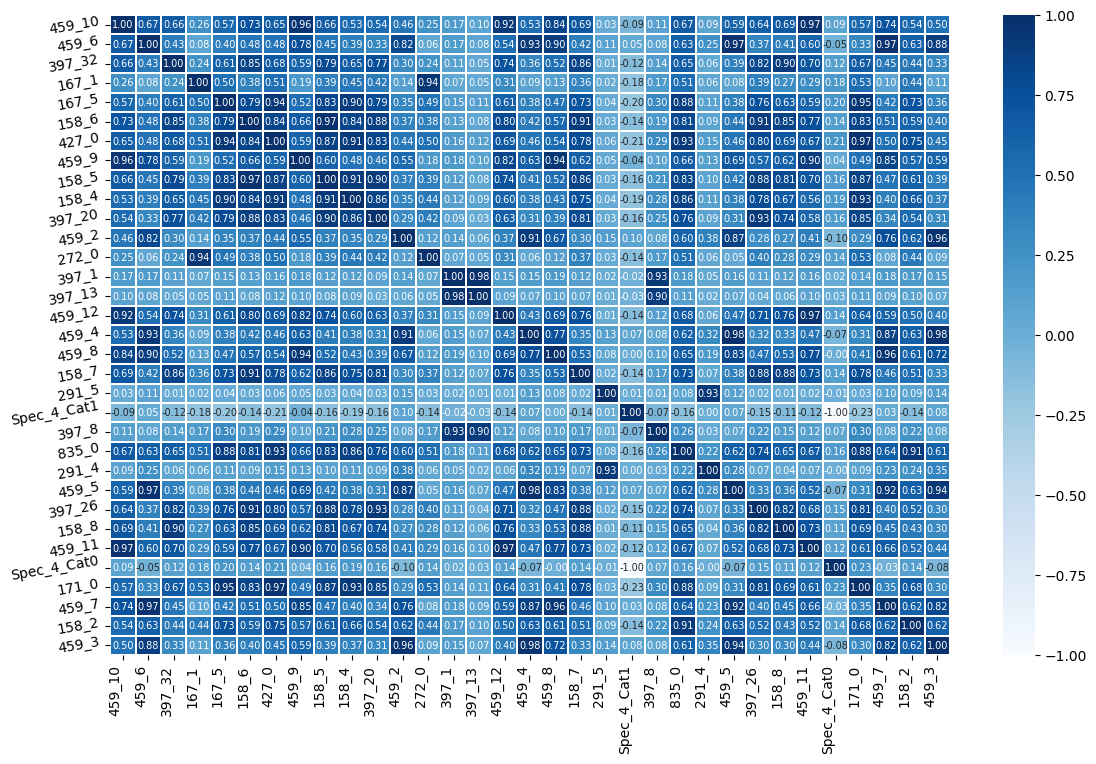

In [59]:
columns_high_corr= list(set(high_correlation_features_all))


heatmap =sns.heatmap(df2[columns_high_corr].corr(),annot=True,cmap='Blues',linewidths=0.2, annot_kws={"size": 7}, fmt ='.2f', xticklabels=True, yticklabels=True)
plt.subplots_adjust(left=0.15, right=0.85, top=0.95, bottom=0.15)
fig=plt.gcf()
fig.set_size_inches(15,8)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(rotation=10, fontsize=10)
plt.show()

In [61]:

main_data1 = dataset_droped_corr.drop(columns= list(set(high_correlation_features)))
main_data =main_data1.drop(columns= ['length_of_study_time_step', 'time_step', 'in_study_repair', 'vehicle_id'], axis = 1)
main_data

666_0     837_0    167_0       167_2       167_3       167_4  \
0      372685.0   41670.0  10415.0  74655621.0  45991626.0  65888583.0   
1      289371.0   68717.0  10415.0  74655621.0  45991626.0  65888583.0   
2      230831.0  100121.0   5918.0  17004223.0  10504195.0  30792854.0   
3      210381.0  152385.0   7128.0  13348382.0  11538870.0  30085352.0   
4      280531.0  164673.0   2688.0  13604867.0  14694395.0  41110339.0   
...         ...       ...      ...         ...         ...         ...   
23545   75859.0   10040.0   6631.0  10519563.0   8797533.0  27117757.0   
23546  138179.0   35726.0  15397.0  11640261.0   7568543.0  19594203.0   
23547  118371.0    9122.0   6783.0   6551850.0   6232055.0  17999988.0   
23548   80078.0   11251.0    755.0  16152271.0   7956861.0  17692205.0   
23549   52949.0   15222.0    843.0  16274631.0   8095988.0  20056805.0   

            167_6      167_7     167_8     167_9  ...  Spec_6_Cat9  \
0       5813857.0     3351.0       0.0       0.0  ...            0   
1       5813857.0     3351.0       0.0       0.0  ...            0   
2      27370868.0  3819383.0  293456.0  101162.0  ...            0   
3      53625651.0  1225967.0    7593.0       0.0  ...            0   
4      15011017.0   689121.0   43760.0   13999.0  ...            0   
...           ...        ...       ...       ...  ...          ...   
23545   6053328.0    32612.0       0.0       0.0  ...            0   
23546  48183109.0  1682930.0   52639.0       0.0  ...            0   
23547  12452989.0   108785.0       0.0       0.0  ...            0   
23548   9509643.0   483602.0    2240.0       0.0  ...            0   
23549  13475823.0  1127331.0   84195.0    6380.0  ...            0   

       Spec_7_Cat0  Spec_7_Cat1  Spec_7_Cat2  Spec_7_Cat4  Spec_7_Cat5  \
0                1            0            0            0            0   
1                0            1            0            0            0   
2                0            1            0            0            0   
3                0            1            0            0            0   
4                0            1            0            0            0   
...            ...          ...          ...          ...          ...   
23545            0            0            0            1            0   
23546            0            0            0            1            0   
23547            0            0            0            1            0   
23548            0            0            0            1            0   
23549            0            0            0            1            0   

       Spec_7_Cat6  Spec_7_Cat7  status   RUL  
0                0            0   False   2.6  
1                0            0   False   0.8  
2                0            0   False   2.2  
3                0            0   False   7.0  
4                0            0   False   2.8  
...            ...          ...     ...   ...  
23545            0            0   False  24.8  
23546            0            0   False   1.4  
23547            0            0   False   7.0  
23548            0            0   False   0.2  
23549            0            0   False   4.4  

[23550 rows x 80 columns]

Split to train and test, 80/20

In [62]:
x_train, x_test, y_train, y_test = train_test_split(shuffle(main_data), main_data['status'], test_size=0.2, random_state= random_state,
                                                    stratify= main_data['status'])


Train X and Train y

In [63]:
# Preprocessing for target variable for train dataset

train_y = list(x_train.loc[:, ["status", "RUL"]].itertuples(index = None, name = None))
train_y = np.array(train_y, dtype=[('status', bool), ('RUL', float)])


train_X = x_train.drop(columns= ['RUL','status'], axis = 1)
train_X.shape

(18840, 78)

In [64]:
# Preprocessing for target variable for train dataset

test_y = list(x_test.loc[:, ["status", "RUL"]].itertuples(index = None, name = None))
test_y = np.array(test_y, dtype=[('status', bool), ('RUL', float)])


test_X = x_test.drop(columns= ['RUL','status'], axis = 1)
test_X.shape

(4710, 78)

In [65]:
rsf = RandomSurvivalForest(
    n_estimators=200, max_depth= 30, max_features='log2',  min_samples_split=30, min_samples_leaf=10, n_jobs = -1, random_state=random_state
)
rsf.fit(train_X, train_y)

RandomSurvivalForest(max_depth=30, max_features='log2', min_samples_leaf=10,
                     min_samples_split=30, n_estimators=200, n_jobs=-1,
                     random_state=12345)

In [66]:
rsf.score(train_X, train_y)

0.9418428871865578

In [67]:
#c-index evaluation metric
rsf.score(test_X, test_y)

0.7105463801736532

COX

In [68]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
estimator = CoxPHSurvivalAnalysis().fit(train_X, train_y)

\\GOOFY2\HT21\moka6903\Desktop\Code\venv\venv\Lib\site-packages\sksurv\linear_model\coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=3.18407e-21): result may not be accurate.
  delta = solve(
\\GOOFY2\HT21\moka6903\Desktop\Code\venv\venv\Lib\site-packages\sksurv\linear_model\coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=7.67569e-22): result may not be accurate.
  delta = solve(
\\GOOFY2\HT21\moka6903\Desktop\Code\venv\venv\Lib\site-packages\sksurv\linear_model\coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=3.06754e-22): result may not be accurate.
  delta = solve(
\\GOOFY2\HT21\moka6903\Desktop\Code\venv\venv\Lib\site-packages\sksurv\linear_model\coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=1.11556e-22): result may not be accurate.
  delta = solve(
\\GOOFY2\HT21\moka6903\Desktop\Code\venv\venv\Lib\site-packages\sksurv\linear_model\coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=4.07738e-23): result may not be accurate.
  delta

In [69]:
surv_funcs = estimator.predict_survival_function(test_X)
estimator.score(test_X, test_y)

0.673836969770531

In [70]:
estimator.score(train_X, train_y)

0.6739296557636584

        Variable   Coefficient
0          666_0 -4.800000e-07
1          837_0 -7.900000e-07
2          167_0 -1.790000e-06
3          167_2  2.000000e-08
4          167_3 -1.000000e-08
5          167_4 -0.000000e+00
6          167_6  0.000000e+00
7          167_7 -4.000000e-08
8          167_8  9.000000e-08
9          167_9  8.000000e-08
10         309_0 -7.300000e-07
11         272_0 -4.000000e-08
12         272_1 -4.000000e-08
13         272_2 -0.000000e+00
14         272_3 -0.000000e+00
15         272_4 -0.000000e+00
16         272_5 -0.000000e+00
17         272_6  8.000000e-08
18         272_7 -1.800000e-07
19         272_8  4.710000e-06
20         272_9 -1.862000e-05
21         370_0  0.000000e+00
22         291_3 -5.820000e-06
23         291_5 -2.341000e-05
24         158_1  1.000000e-08
25         158_2  0.000000e+00
26         158_3  1.000000e-08
27         158_7 -6.000000e-08
28         158_9  0.000000e+00
29         100_0  1.000000e-08
30         459_0 -2.359000e-05
31      

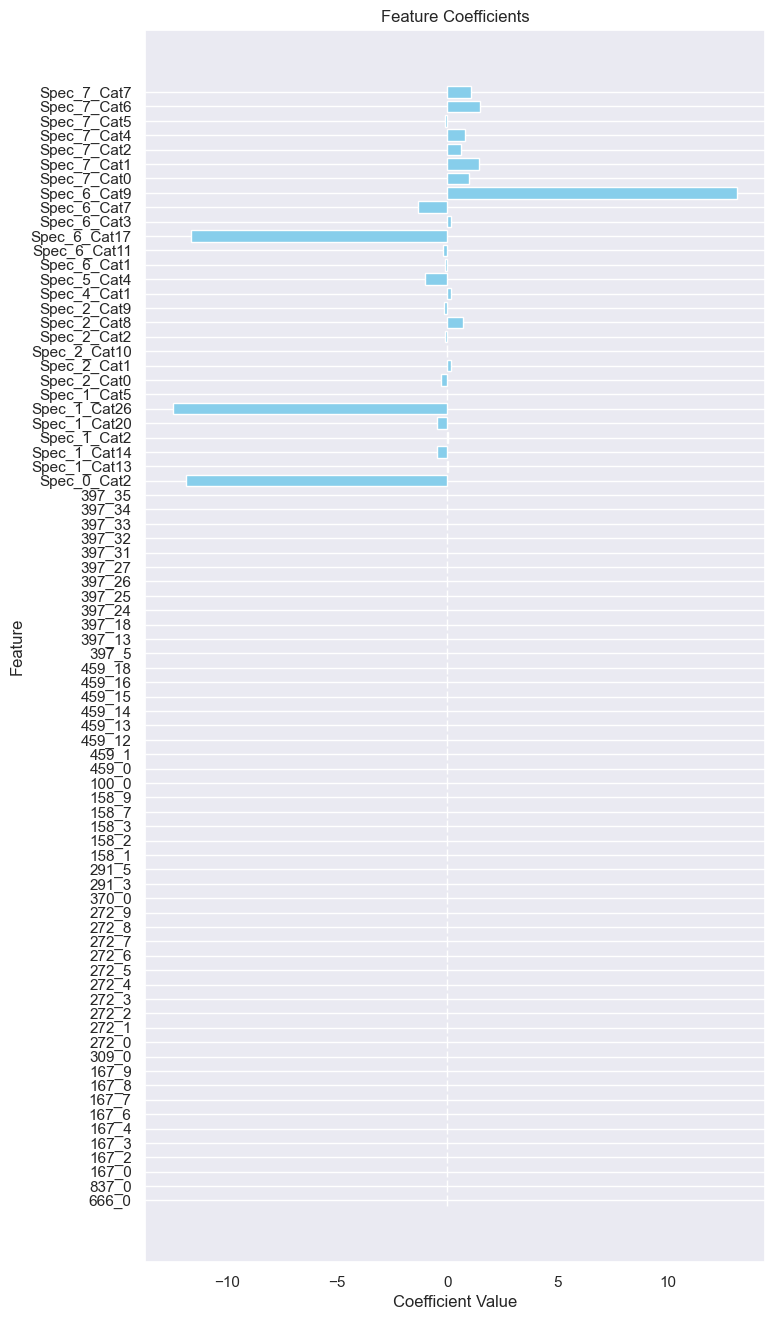

In [134]:
feature_importance = estimator.coef_.round(8)

coef_df = pd.DataFrame({"Variable": test_X.columns, "Coefficient": feature_importance})
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

print(coef_df)
# Plot the coefficients
plt.figure(figsize=(8, 16))
plt.barh(coef_df['Variable'], coef_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Coefficients')
plt.grid(axis='x')
plt.show()

In [23]:
est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=50,min_samples_split =30, min_samples_leaf =20,  learning_rate=0.5, max_depth=6, random_state=random_state)


In [24]:
est_cph_tree.fit(train_X, train_y)


GradientBoostingSurvivalAnalysis(learning_rate=0.5, max_depth=6,
                                 min_samples_leaf=20, min_samples_split=30,
                                 n_estimators=50, random_state=12345)

In [26]:
est_cph_tree.score(train_X, train_y)

0.8321154788873457

In [25]:
cindex = est_cph_tree.score(test_X, test_y)
print(round(cindex, 5))

0.67936


In [25]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, test_X, test_y, n_repeats=10, random_state=random_state)

In [26]:
# Get the indices of the features sorted by importance
importance_scores = result.importances_mean
indices_sorted = np.argsort(-importance_scores)

# Get the names of the top 30 most important features
top_30_feature_names = [test_X.columns[i] for i in indices_sorted[:30]]

print(top_30_feature_names)

['272_0', '666_0', '158_3', '167_2', '158_1', '459_14', '459_15', '272_2', '158_9', '272_4', '272_1', '459_0', '100_0', '397_26', '397_32', '167_4', '158_7', '167_3', '167_6', '272_6', '291_3', '167_7', '397_34', '397_13', '397_25', '397_31', '459_12', '837_0', '158_2', '397_33']


In [27]:
rsf_feature_imp = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=test_X.columns,
).sort_values(by="importances_mean", ascending=False)

rsf_feature_imp.iloc[:30,:]

importances_mean  importances_std
272_0           0.008823         0.002901
666_0           0.007749         0.002816
158_3           0.007272         0.001398
167_2           0.005970         0.002831
158_1           0.005809         0.001652
459_14          0.005367         0.002353
459_15          0.005359         0.001376
272_2           0.005245         0.001201
158_9           0.004232         0.001678
272_4           0.003997         0.000942
272_1           0.003859         0.001725
459_0           0.003250         0.002224
100_0           0.002992         0.001054
397_26          0.002844         0.001207
397_32          0.002738         0.002085
167_4           0.002457         0.001268
158_7           0.002277         0.001640
167_3           0.002223         0.001224
167_6           0.002209         0.002236
272_6           0.001958         0.001449
291_3           0.001866         0.002439
167_7           0.001840         0.001238
397_34          0.001751         0.001564
397_13          0.001733         0.001600
397_25          0.001702         0.001321
397_31          0.001529         0.001300
459_12          0.001478         0.001261
837_0           0.001459         0.001618
158_2           0.001192         0.000970
397_33          0.001191         0.001312

In [21]:
top_30_feature_names = ['272_0', '666_0', '158_3', '167_2', '158_1', '459_14', '459_15', '272_2', '158_9', '272_4', '272_1', '459_0', '100_0', '397_26', '397_32', '167_4', '158_7', '167_3', '167_6', '272_6', '291_3', '167_7', '397_34', '397_13', '397_25', '397_31', '459_12', '837_0', '158_2', '397_33']

In [22]:
X_train_subset = train_X[top_30_feature_names]
rsf = RandomSurvivalForest(
    n_estimators=200, max_depth= 30, max_features='log2',  min_samples_split=30, min_samples_leaf=10, n_jobs = -1, random_state=random_state
)


rsf.fit(X_train_subset, train_y)

RandomSurvivalForest(max_depth=30, max_features='log2', min_samples_leaf=10,
                     min_samples_split=30, n_estimators=200, n_jobs=-1,
                     random_state=12345)

In [23]:
rsf.score(X_train_subset, train_y)

0.9401800512303561

In [24]:
#c-index evaluation metric
X_test_subset = test_X[top_30_feature_names]
rsf.score(X_test_subset, test_y)

0.7010359275979507

100%|===================| 4706/4710 [11:23<00:00]        

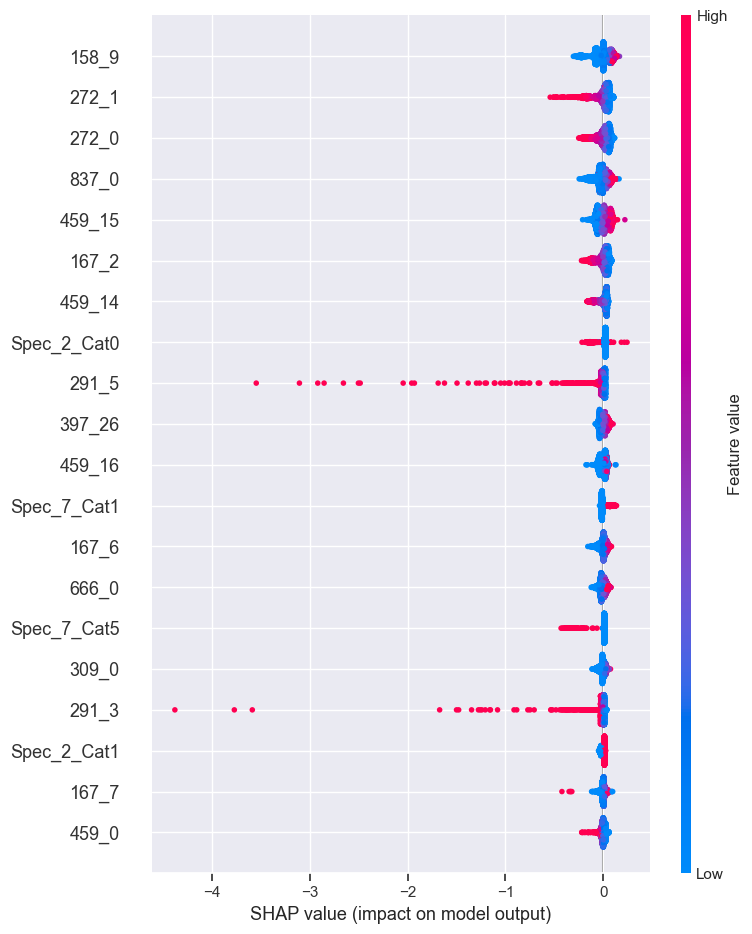

In [130]:
shap_values = explainer.shap_values(X_testt)
shap.summary_plot(shap_values, X_testt)


SHAP analysis

In [103]:
import shap
from sksurv.ensemble import RandomSurvivalForest
from sklearn.cluster import KMeans

#X_testt = X_subsample_test
#X_trainn = X_subsample_train
#with all vehicles and selected features
#X_trainn = X_train_subset
#X_testt = X_test_subset
#with all vehicles and all features
X_testt = test_X
X_trainn = train_X



survival_probabilities = rsf.predict_survival_function(X_testt, return_array=True)

# Cluster survival probabilities into three risk categories
kmeans = KMeans(n_clusters=5, random_state=random_state)
risk_categories = kmeans.fit_predict(survival_probabilities)


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [86]:
import shap
from sklearn.ensemble import RandomForestRegressor
#X_testt = X_subsample_test
#X_trainn = X_subsample_train
X_testt = test_X
X_trainn = train_X

# Load a sample survival dataset (e.g., veterans lung cancer dataset)


# Train a Random Survival Forest model
#rsf = RandomSurvivalForest(n_estimators=200, max_depth= 30, max_features='log2',  min_samples_split=30, min_samples_leaf=10, n_jobs = -1, random_state=random_state)
#rsf.fit(X_trainn, train_y)

# Convert RandomSurvivalForest to a RandomForestRegressor (surrogate model)
# using the predicted survival times as the target variable
surrogate_model = RandomForestRegressor(n_estimators=200, max_depth= 30, max_features='log2',  min_samples_split=30, min_samples_leaf=10, n_jobs = -1, random_state=random_state)
surrogate_model.fit(X_trainn, rsf.predict(X_trainn))

# Create a SHAP explainer for the surrogate model
explainer = shap.Explainer(surrogate_model, X_trainn)

all vehicles (4710, 78)


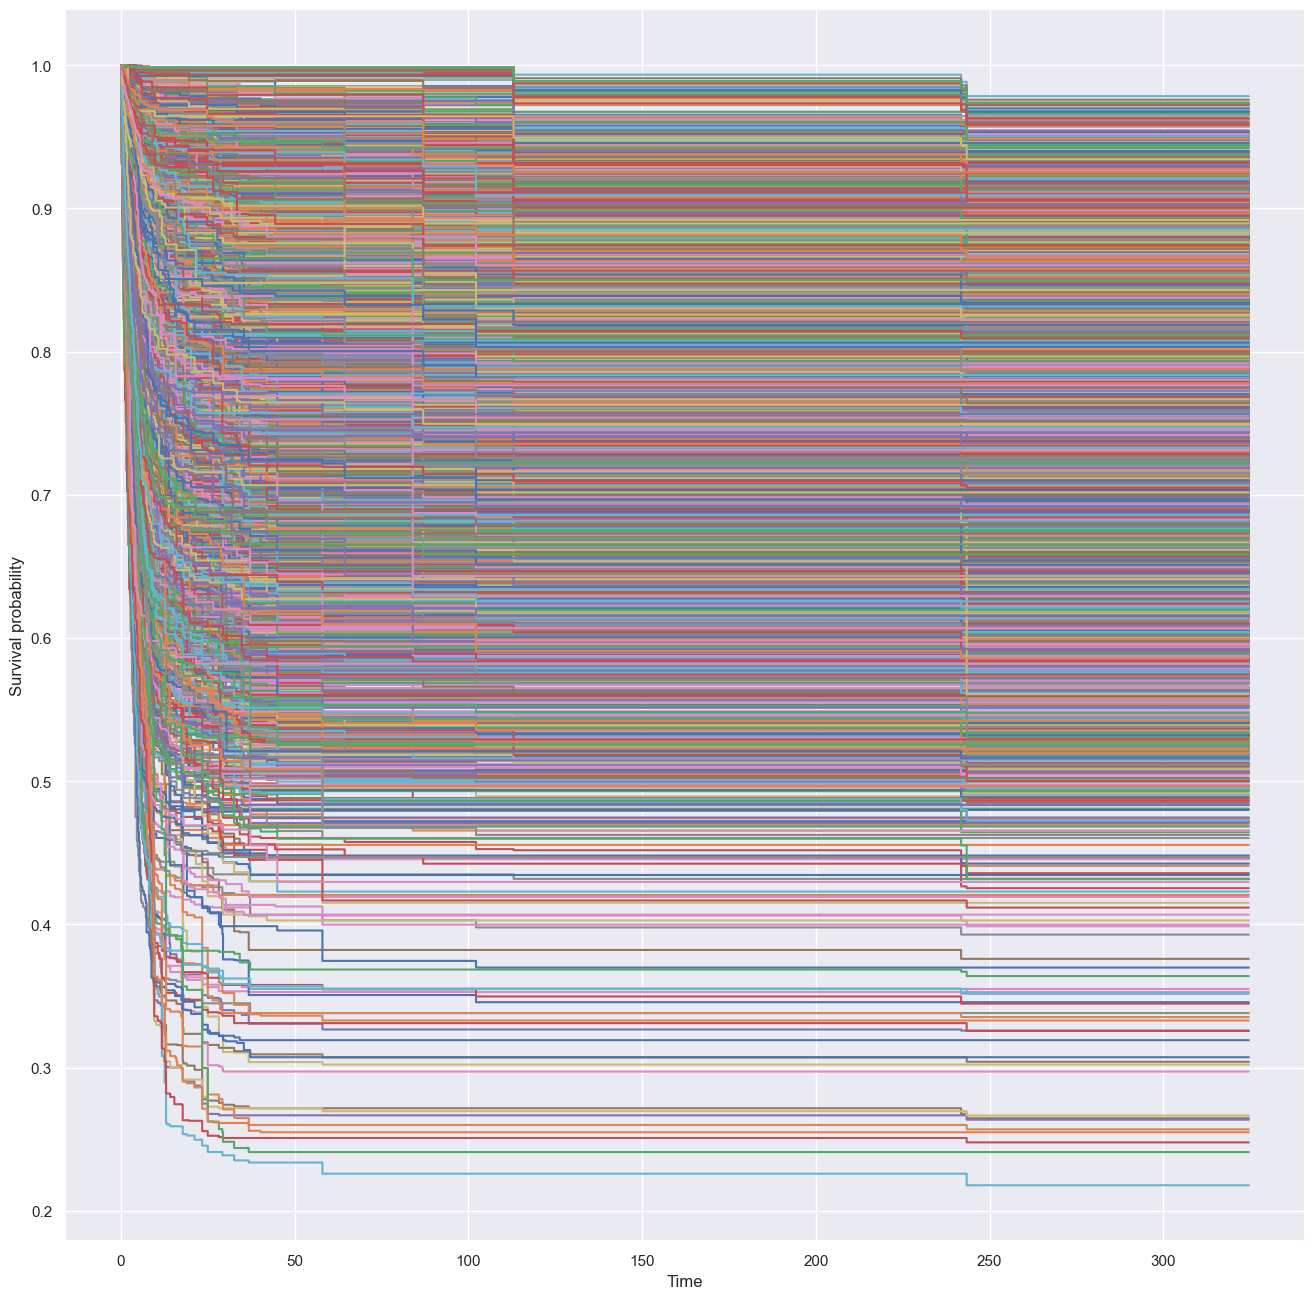

In [122]:
X_risk = X_testt
surv = rsf.predict_survival_function(X_risk, return_array=True)
sns.set(rc = {'figure.figsize':(16,16)})
for j, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(j))
        
plt.ylabel("Survival probability")
plt.xlabel("Time")

    #plt.legend()
plt.grid(True)
print('all vehicles', X_testt.shape)

category 1 (731, 78)


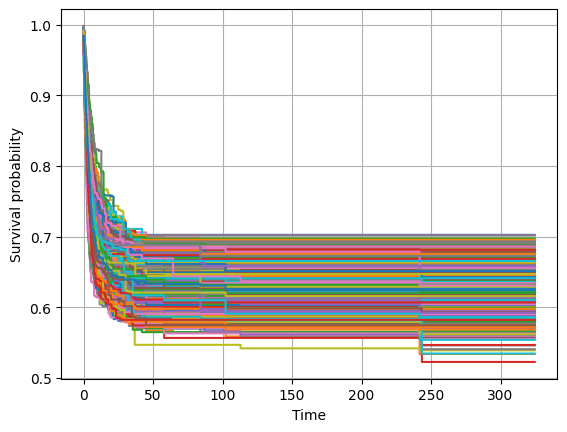

In [115]:
#for i in range(3):
    # Select data points in the current risk category
X_risk = X_testt[risk_categories == 1]
surv = rsf.predict_survival_function(X_risk, return_array=True)
    #sns.set(rc = {'figure.figsize':(16,16)})
for j, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(j))
        
plt.ylabel("Survival probability")
plt.xlabel("Time")

    #plt.legend()
plt.grid(True)
print('category 1', X_testt[risk_categories == 1].shape)

category 2 (1311, 78)


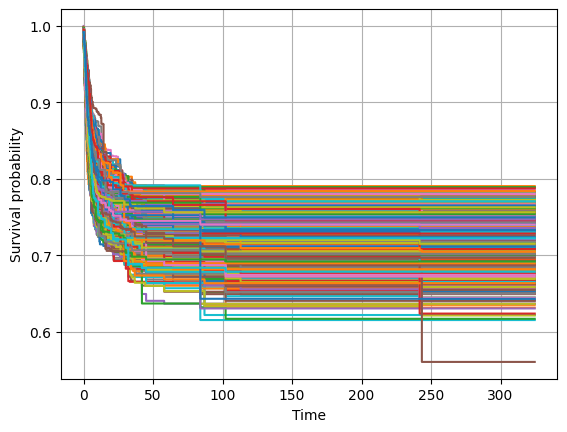

In [116]:
X_risk = X_testt[risk_categories == 2]
surv = rsf.predict_survival_function(X_risk, return_array=True)
    #sns.set(rc = {'figure.figsize':(16,16)})
for j, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(j))
        
plt.ylabel("Survival probability")
plt.xlabel("Time")

    #plt.legend()
plt.grid(True)
print('category 2', X_testt[risk_categories == 2].shape)

category 3 (255, 78)


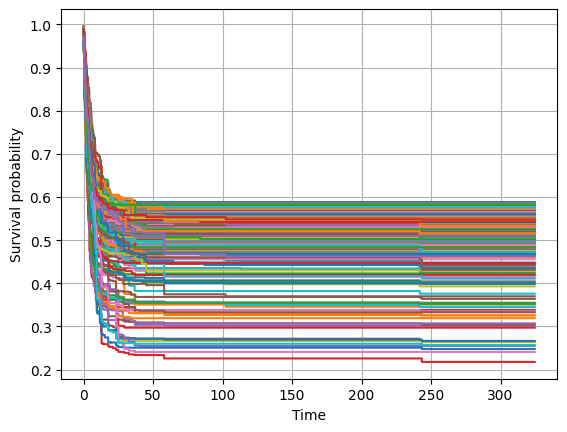

In [117]:
X_risk = X_testt[risk_categories == 3]
surv = rsf.predict_survival_function(X_risk, return_array=True)
    #sns.set(rc = {'figure.figsize':(16,16)})
for j, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(j))
        
plt.ylabel("Survival probability")
plt.xlabel("Time")

    #plt.legend()
plt.grid(True)
print('category 3', X_testt[risk_categories == 3].shape)

category 4 (985, 78)


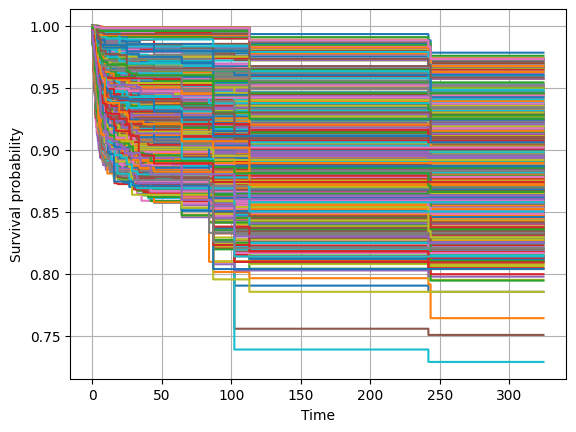

In [118]:
X_risk = X_testt[risk_categories == 4]
surv = rsf.predict_survival_function(X_risk, return_array=True)
    #sns.set(rc = {'figure.figsize':(16,16)})
for j, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(j))
        
plt.ylabel("Survival probability")
plt.xlabel("Time")

    #plt.legend()
plt.grid(True)
print('category 4', X_testt[risk_categories == 4].shape)

category 0 (1428, 78)


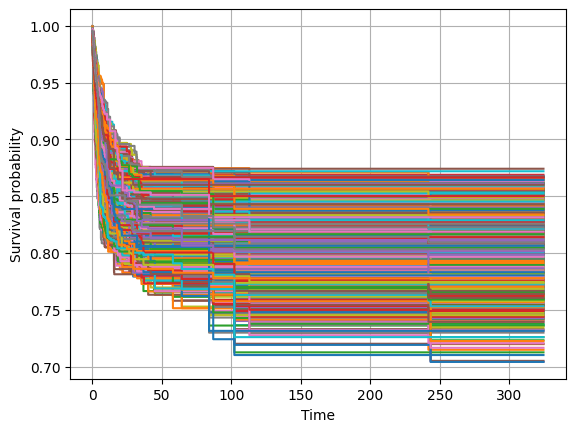

In [120]:
X_risk = X_testt[risk_categories == 0]
surv = rsf.predict_survival_function(X_risk, return_array=True)
    #sns.set(rc = {'figure.figsize':(16,16)})
for j, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(j))
        
plt.ylabel("Survival probability")
plt.xlabel("Time")

    #plt.legend()
plt.grid(True)
print('category 0', X_testt[risk_categories == 0].shape)

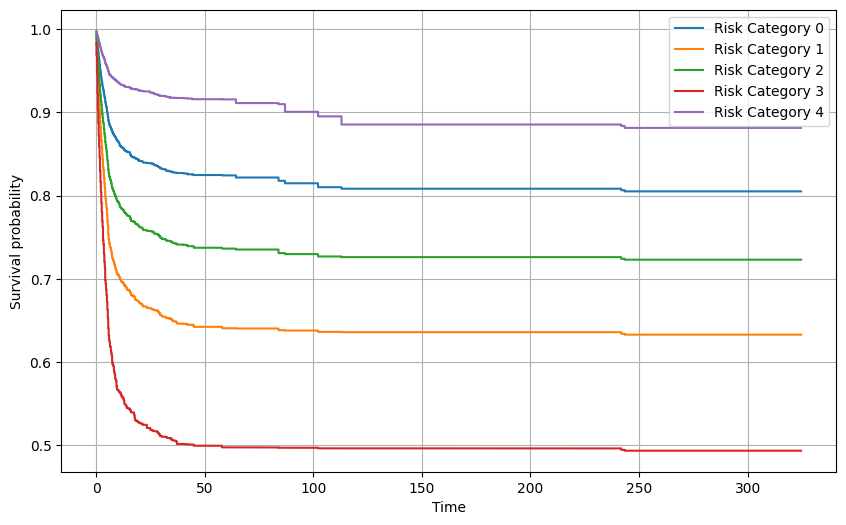

In [104]:
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

# Loop through each risk category
for i in range(5):
    X_risk = X_testt[risk_categories == i]
    surv = rsf.predict_survival_function(X_risk, return_array=True)
    
    # Calculate the mean survival probability across all instances in this category
    mean_survival = np.mean(surv, axis=0)
    
    # Plot the mean survival probability curve for this category
    plt.step(rsf.unique_times_, mean_survival, where="post", label=f"Risk Category {i}")

plt.ylabel("Survival probability")
plt.xlabel("Time")
plt.grid(True)
plt.legend()
plt.show()


100%|===================| 4702/4710 [10:01<00:01]        

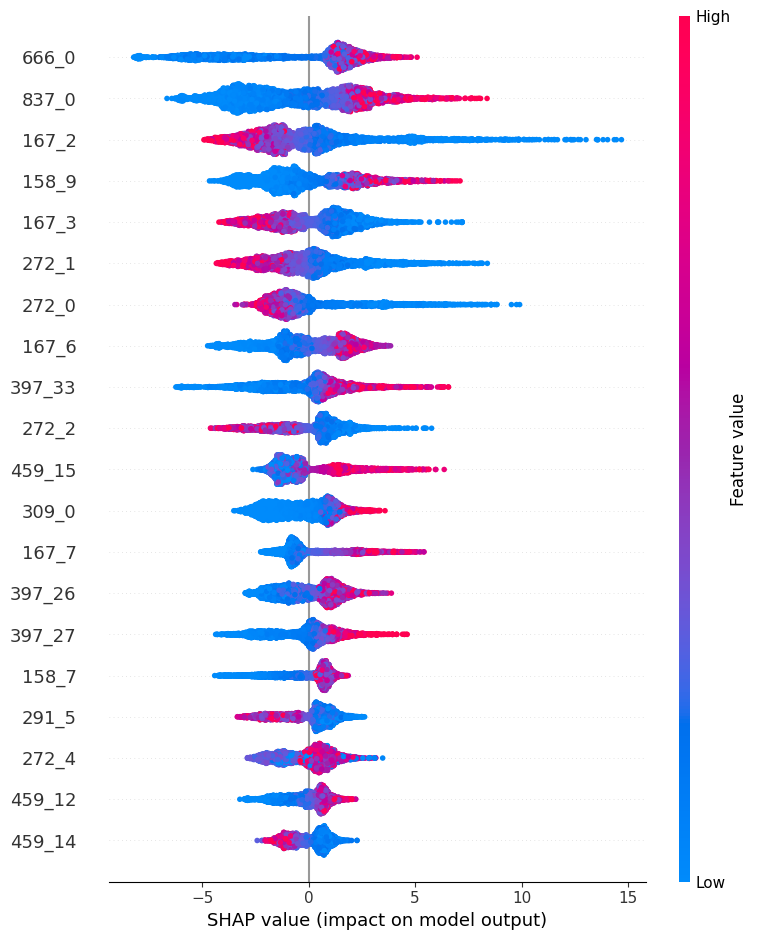

In [87]:
shap_values = explainer.shap_values(X_testt)
shap.summary_plot(shap_values, X_testt)


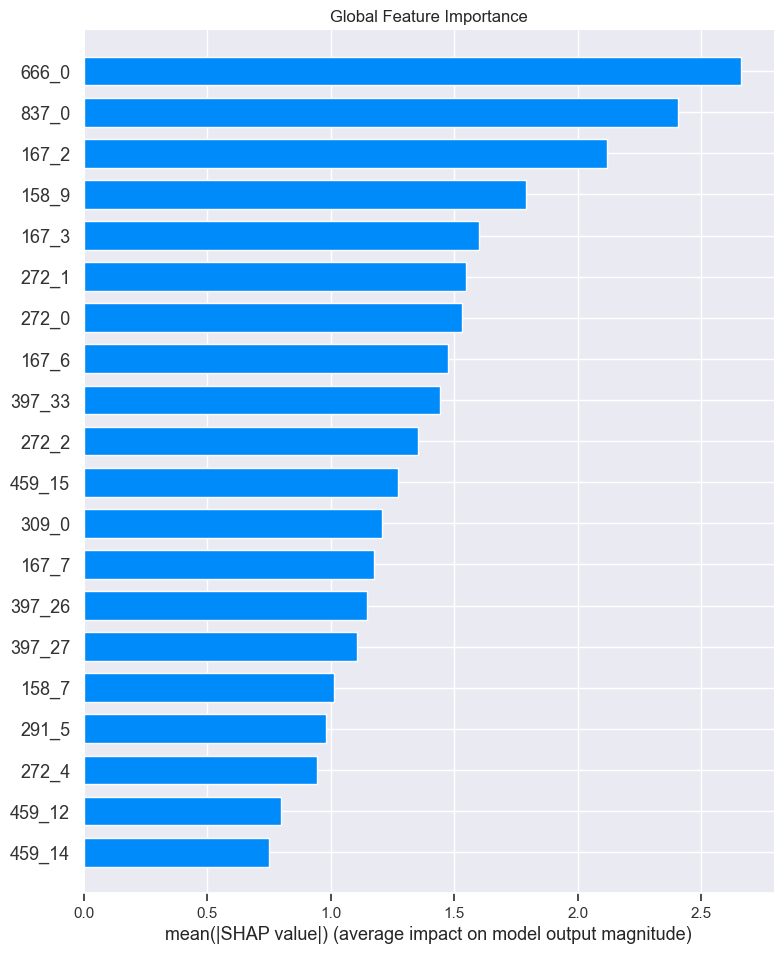

In [123]:
shap.summary_plot(shap_values, X_testt, plot_type='bar', show=False)
plt.title('Global Feature Importance')
plt.show()

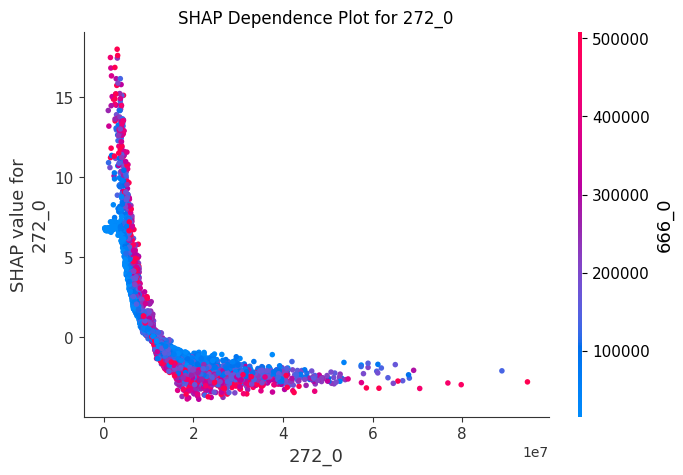

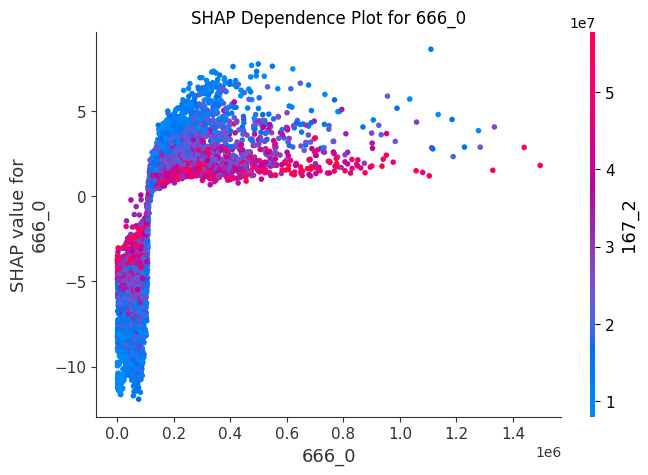

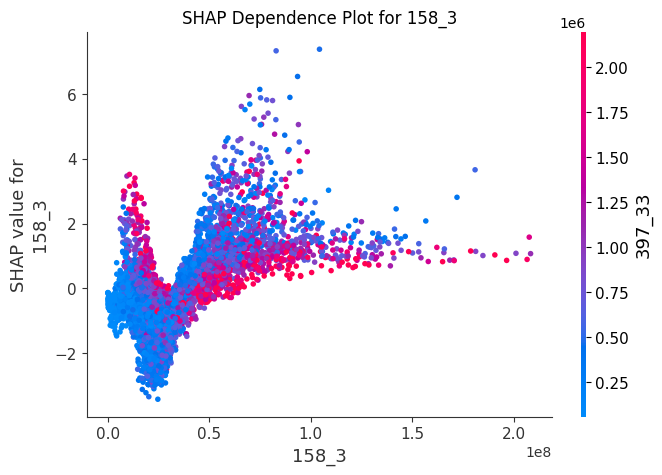

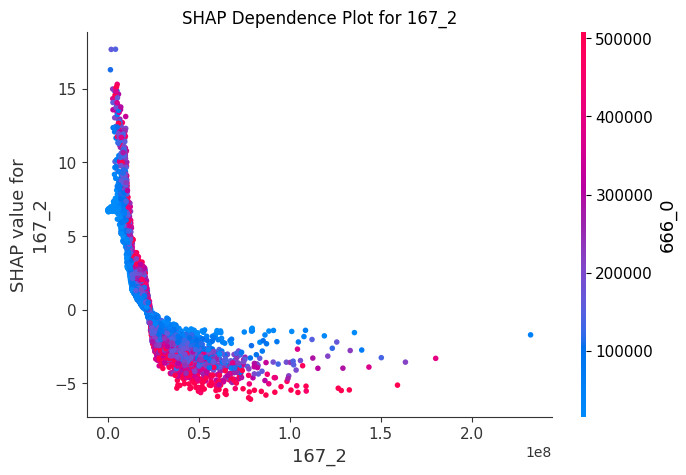

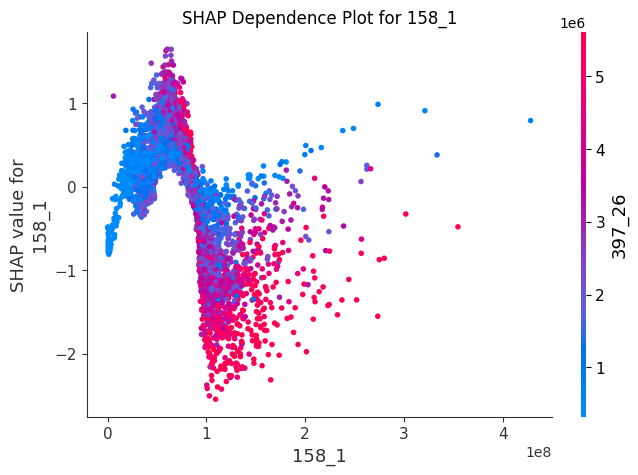

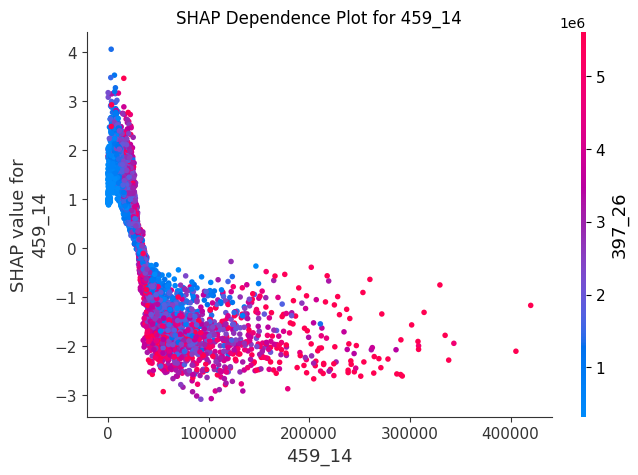

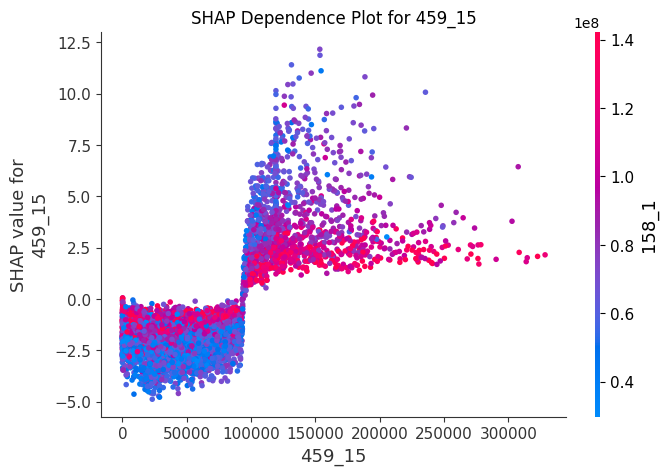

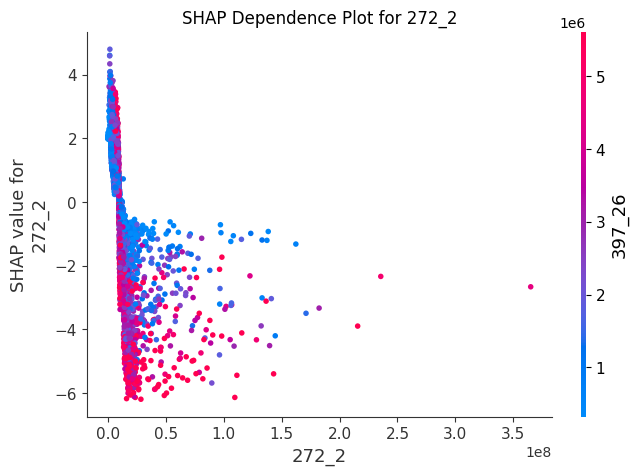

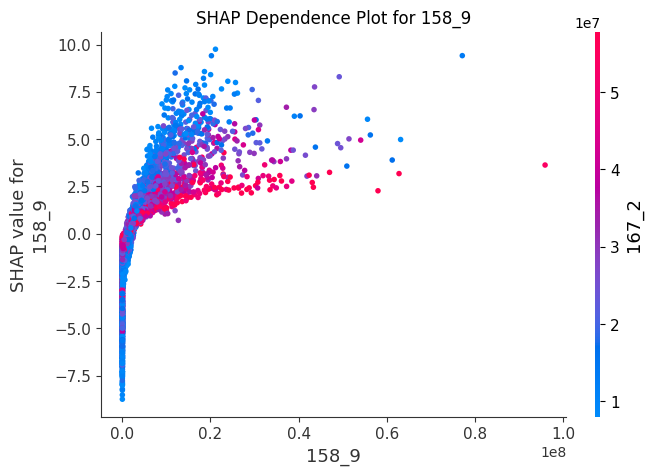

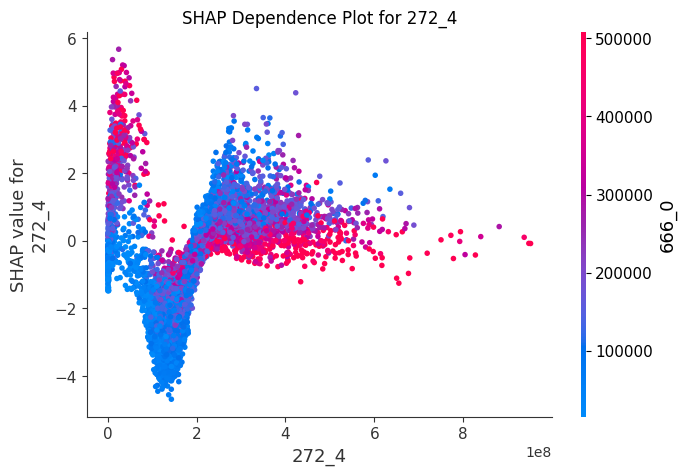

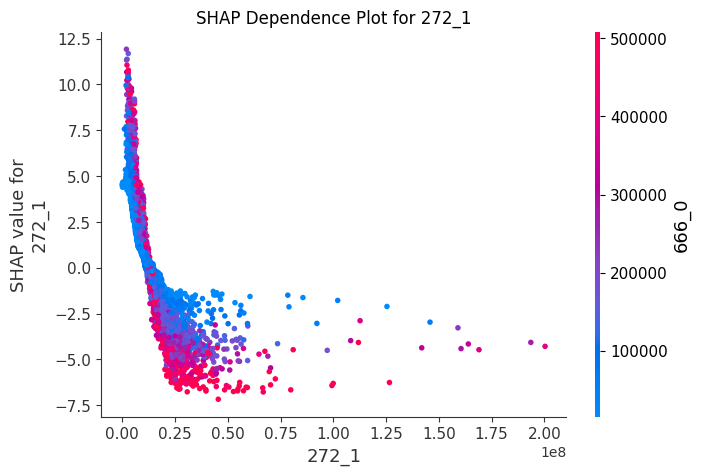

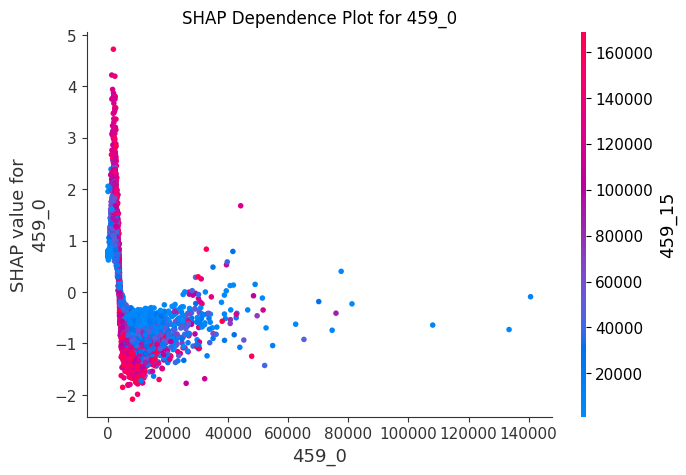

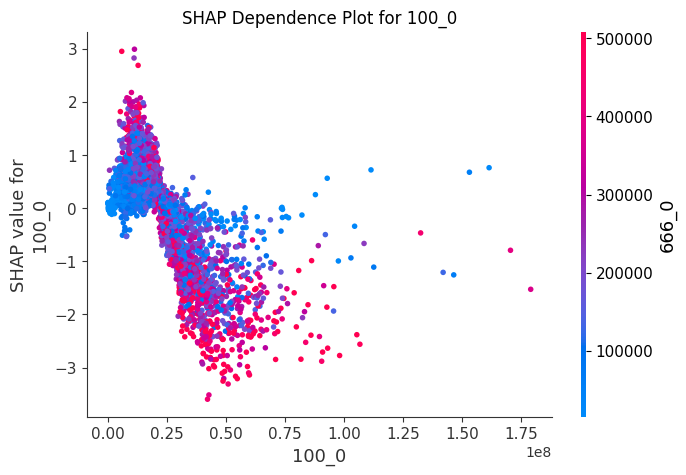

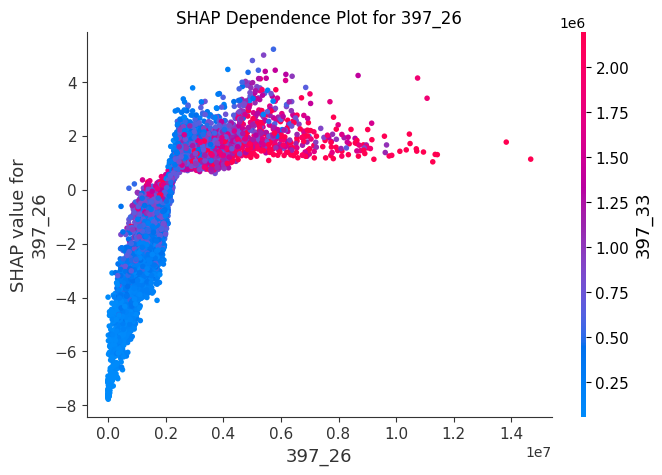

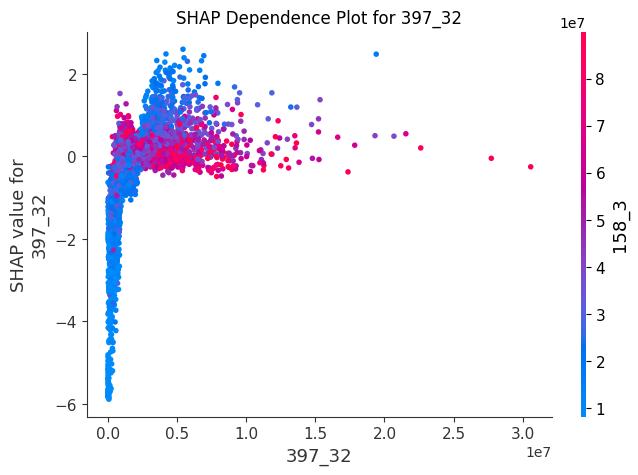

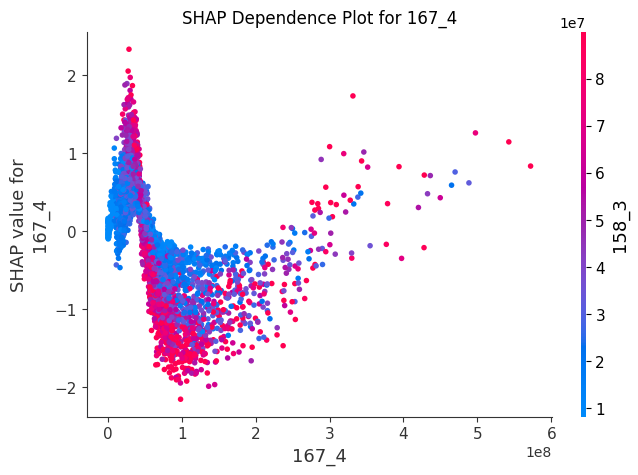

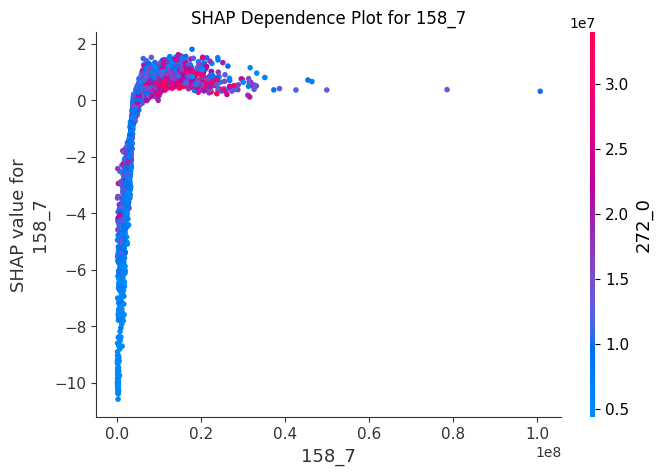

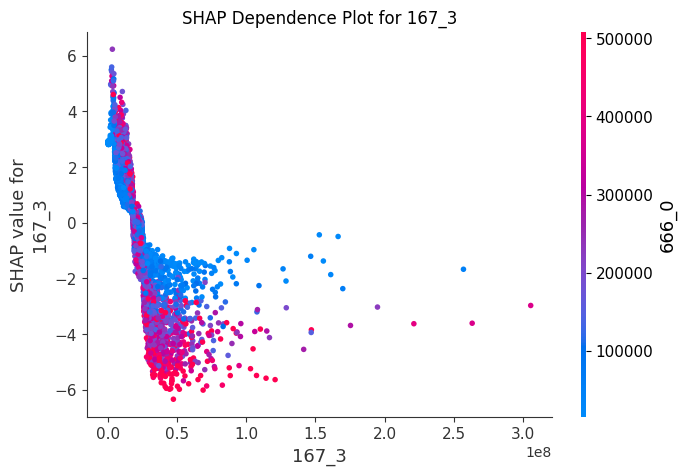

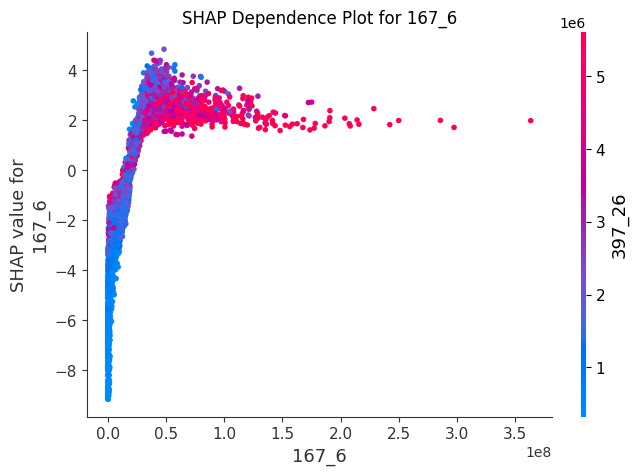

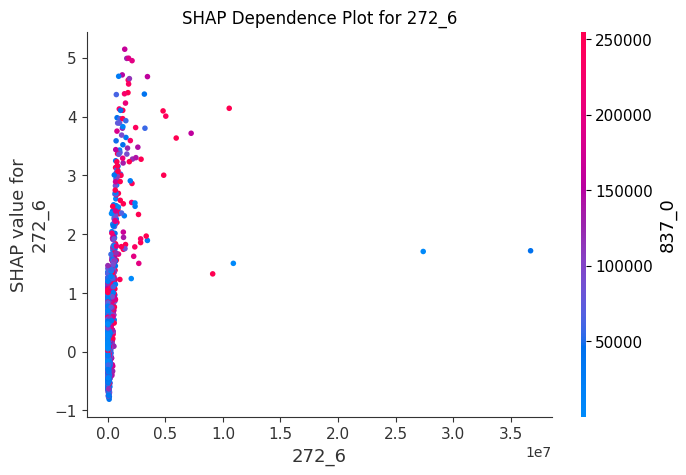

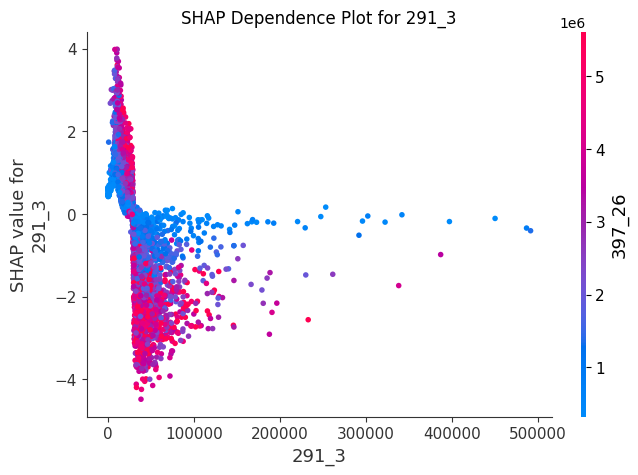

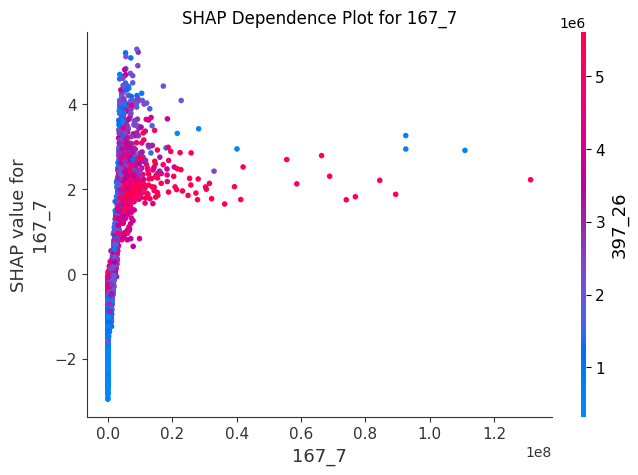

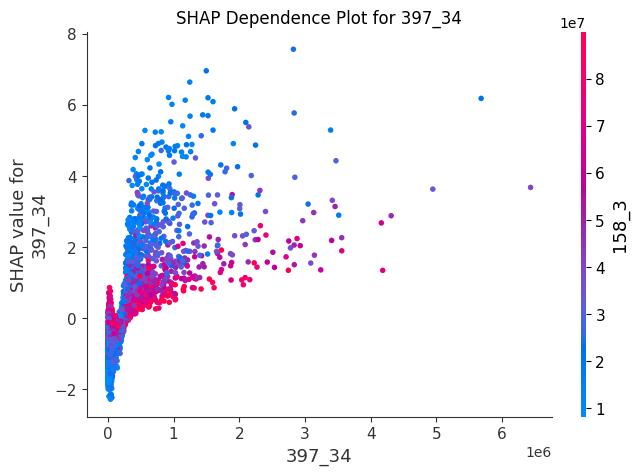

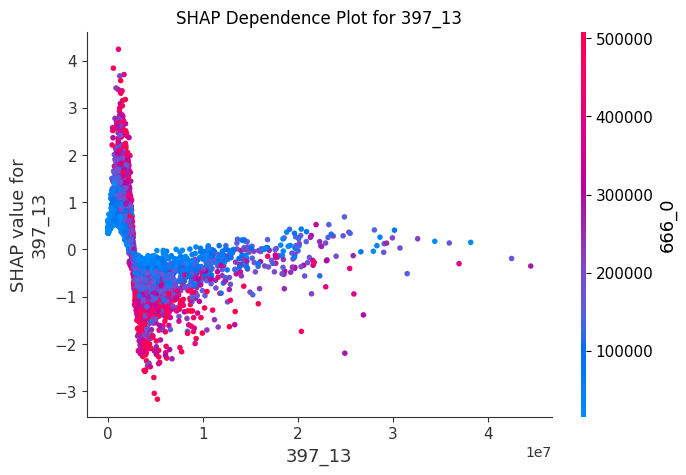

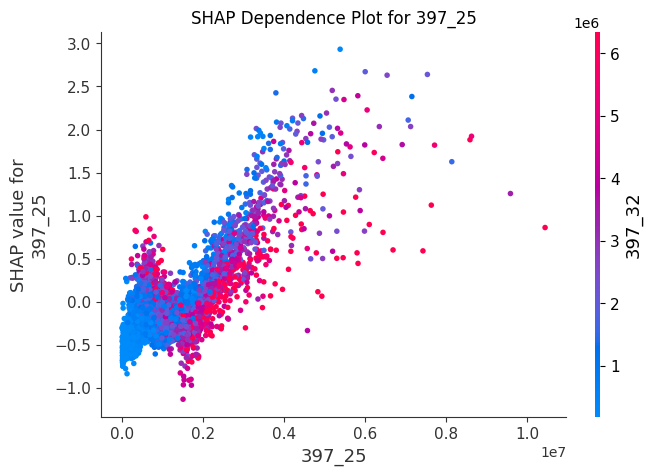

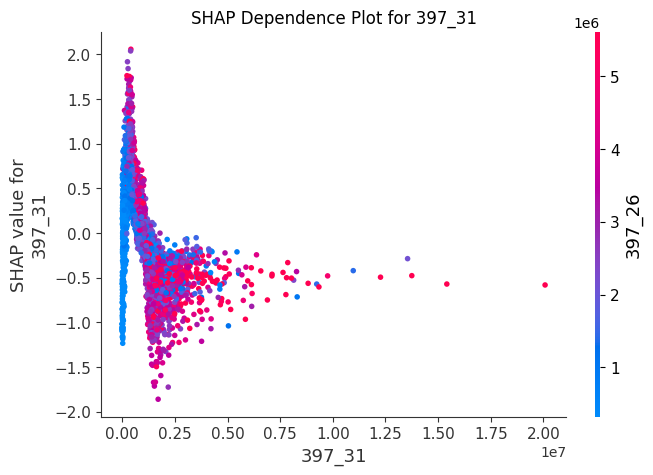

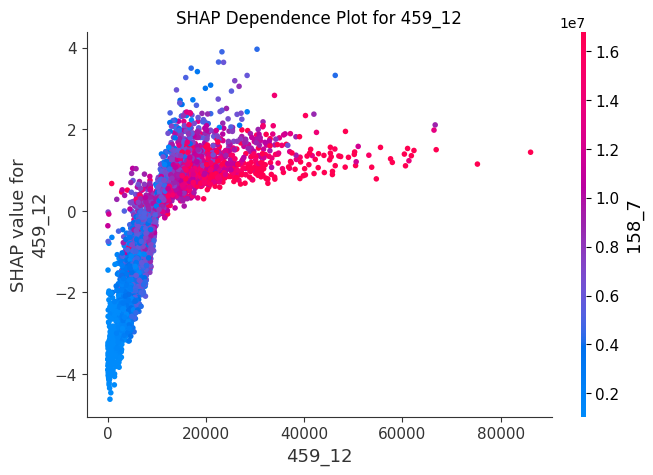

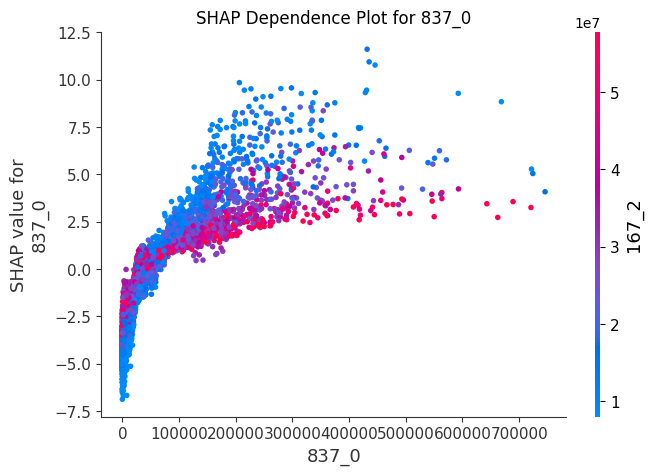

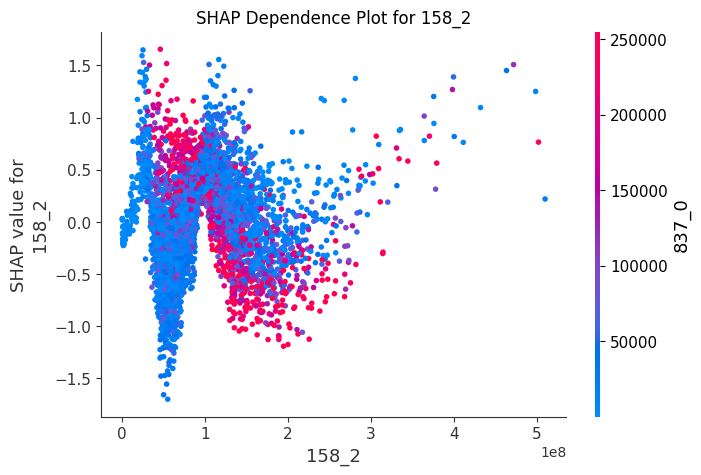

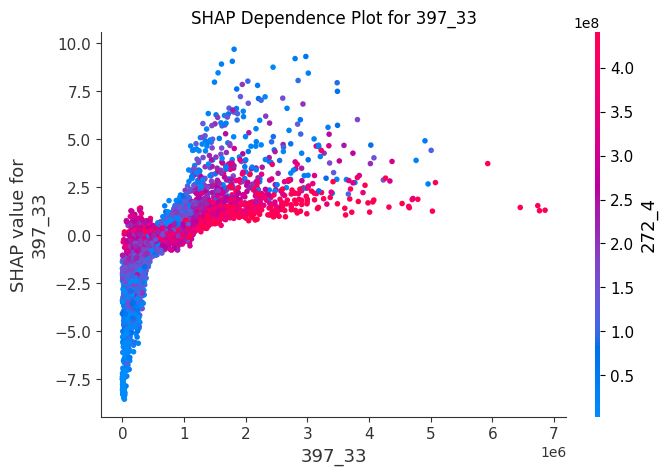

In [46]:
# Plot SHAP dependence plots for each feature
for feature_name in X_testt.columns:
    shap.dependence_plot(feature_name,shap_values, X_testt, show=False)
    plt.title(f'SHAP Dependence Plot for {feature_name}')
    plt.show()

Vehicle ID corresponding to choosed index: 32859


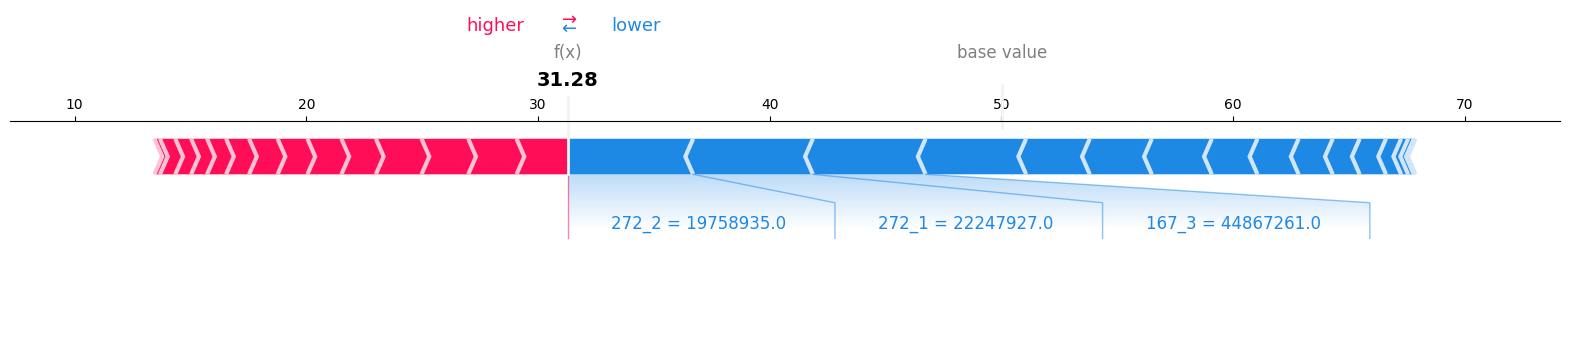

In [112]:
# Choose a specific instance for local explanation (i = 15)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
i = 50
instance_index = i # Find the index of the first instance from the current category
instance = X_testt.iloc[instance_index]  # Get the instance from the test set
    
# Calculate SHAP values for the chosen instance
shap_values_instance = shap_values[instance_index]

expected_value1 = explainer.expected_value
# Get the Vehicle ID corresponding to the specified index
index_to_lookup = instance.name
vehicle_id = dataset_ffil.loc[index_to_lookup, 'vehicle_id']
print(f"Vehicle ID corresponding to choosed index: {vehicle_id}")


shap.initjs()
# Plot local SHAP force plot for the chosen instance
shap.force_plot(expected_value1, shap_values_instance, instance , matplotlib=True)

In [30]:
# Calculate SHAP values for each risk category


# Select data points in the current risk category
X_risk_0 = X_testt[risk_categories == 0]

# Calculate SHAP values
shap_values_0 = explainer.shap_values(X_risk_0)



100%|===================| 1980/1984 [03:00<00:00]        

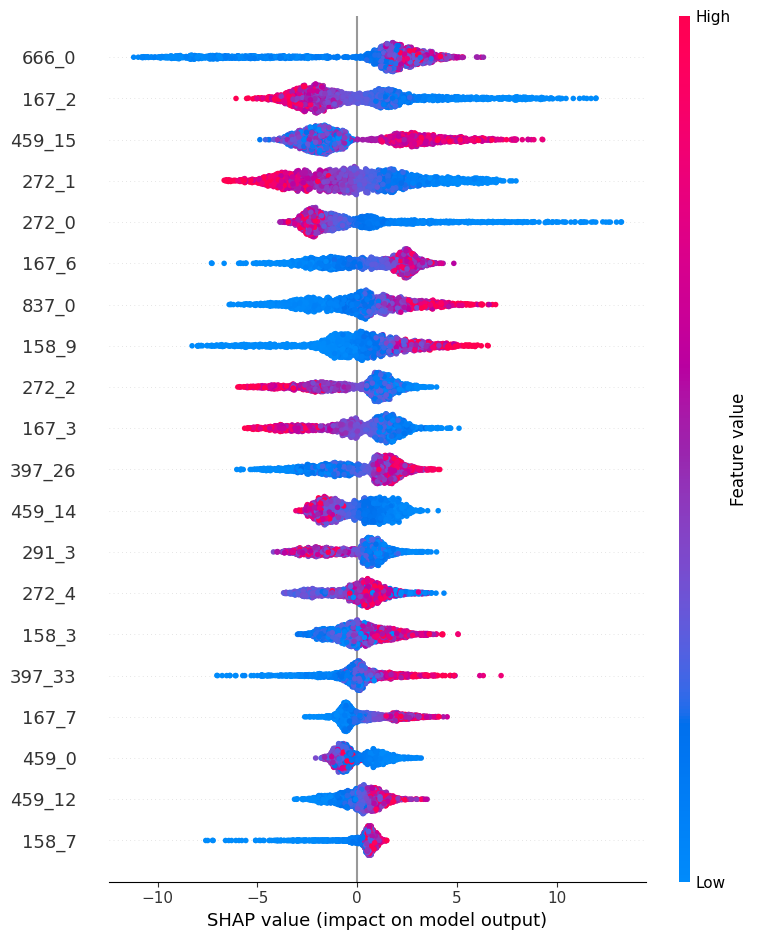

In [31]:
shap.summary_plot(shap_values_0, X_testt[risk_categories == 0])

Create a SHAP dependence plot, colored by an interaction feature.

Plots the value of the feature on the x-axis and the SHAP value of the same feature on the y-axis. This shows how the model depends on the given feature, and is like a richer extenstion of the classical parital dependence plots. Vertical dispersion of the data points represents interaction effects. Grey ticks along the y-axis are data points where the feature’s value was NaN.

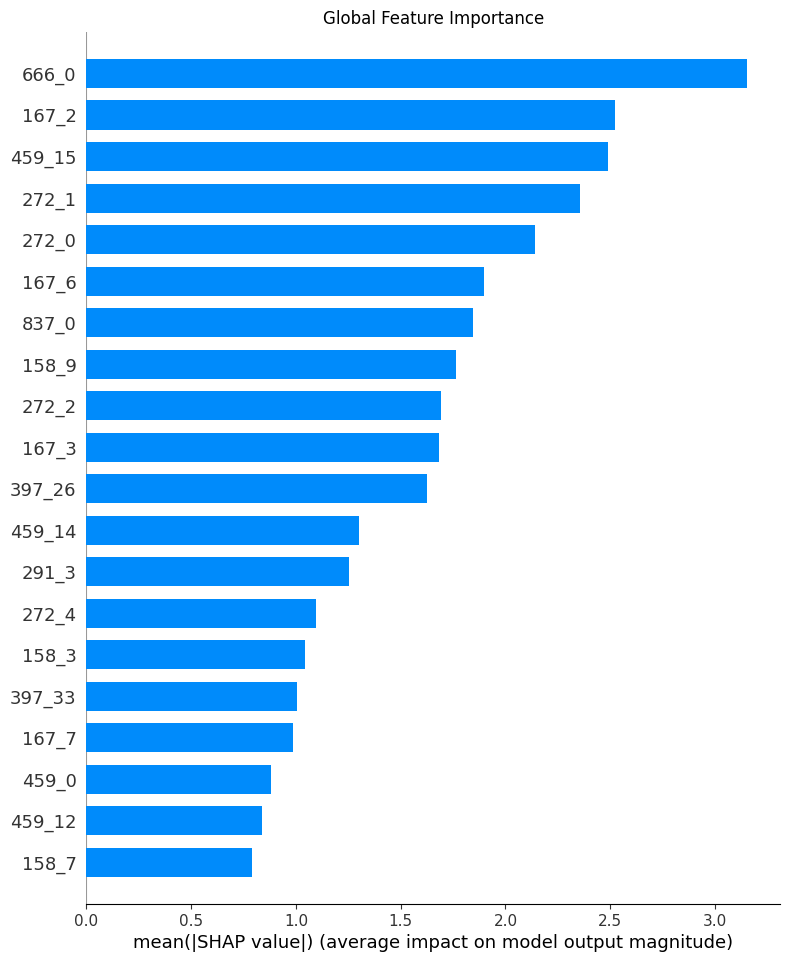

In [35]:
# Plot global feature importance summary plot
shap.summary_plot(shap_values_0, X_testt[risk_categories == 0], plot_type='bar', show=False)
plt.title('Global Feature Importance')
plt.show()

100%|===================| 1993/1998 [03:37<00:00]        

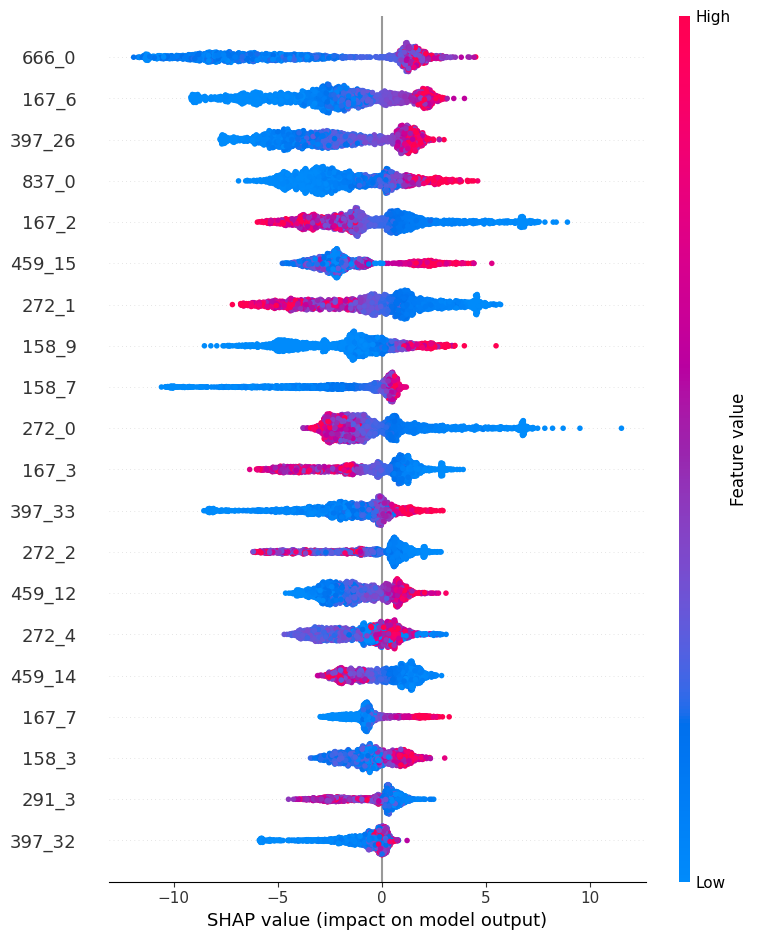

In [32]:
# Calculate SHAP values for each risk category

# Select data points in the current risk category
X_risk1 = X_testt[risk_categories == 1]
# Calculate SHAP values
shap_values1 = explainer.shap_values(X_risk1)
shap.summary_plot(shap_values1, X_testt[risk_categories == 1])


100%|===================| 725/728 [01:05<00:00]        

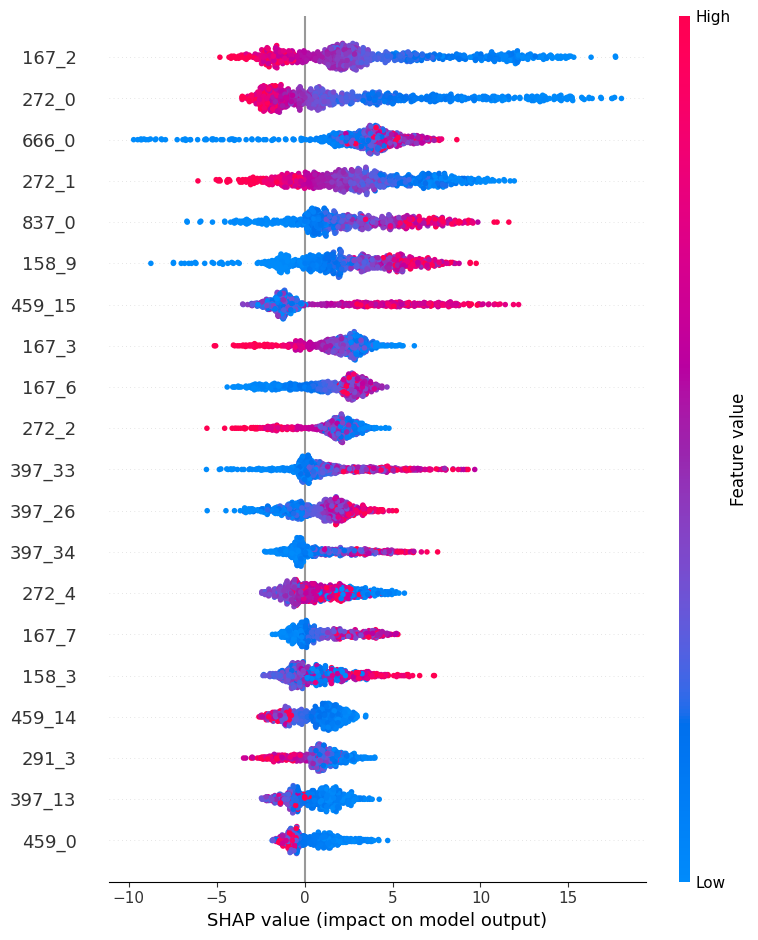

In [33]:
# Calculate SHAP values for each risk category

# Select data points in the current risk category
X_risk2 = X_testt[risk_categories == 2]
# Calculate SHAP values
shap_values2 = explainer.shap_values(X_risk2)
shap.summary_plot(shap_values2, X_testt[risk_categories == 2])


https://towardsdatascience.com/introducing-shap-decision-plots-52ed3b4a1cba

Vehicle ID corresponding to choosed index: 21065


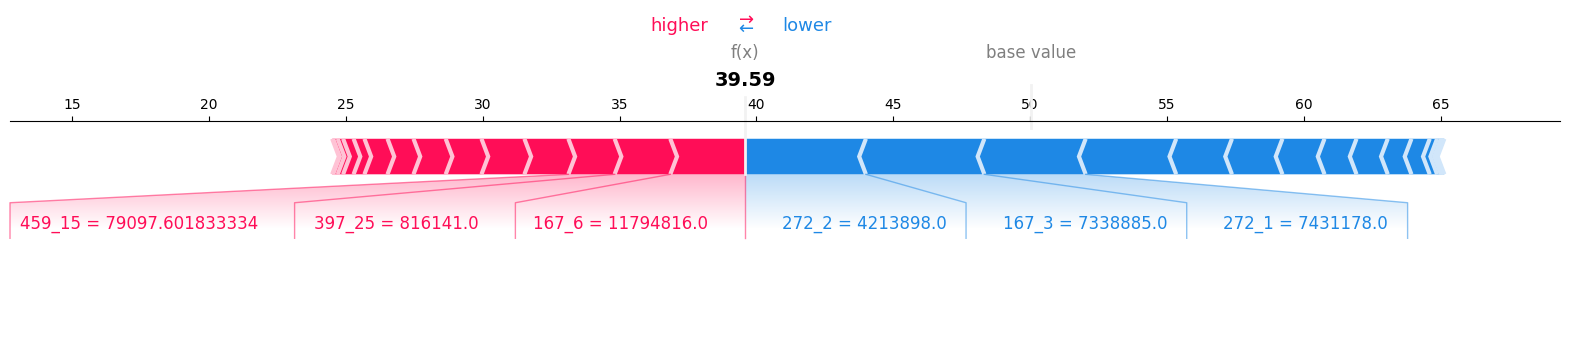

In [109]:
# Choose a specific instance for local explanation (i = 15)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
i = 50
instance_index = np.where(risk_categories == 0)[0][i]  # Find the index of the first instance from the current category
instance = X_testt.iloc[instance_index]  # Get the instance from the test set
    
# Calculate SHAP values for the chosen instance
shap_values_instance = shap_values_0[instance_index]

expected_value1 = explainer.expected_value
# Get the Vehicle ID corresponding to the specified index
index_to_lookup = instance.name
vehicle_id = dataset_ffil.loc[index_to_lookup, 'vehicle_id']
print(f"Vehicle ID corresponding to choosed index: {vehicle_id}")


shap.initjs()
# Plot local SHAP force plot for the chosen instance
shap.force_plot(expected_value1, shap_values_instance, instance , matplotlib=True)

100%|===================| 254/255 [00:32<00:00]        

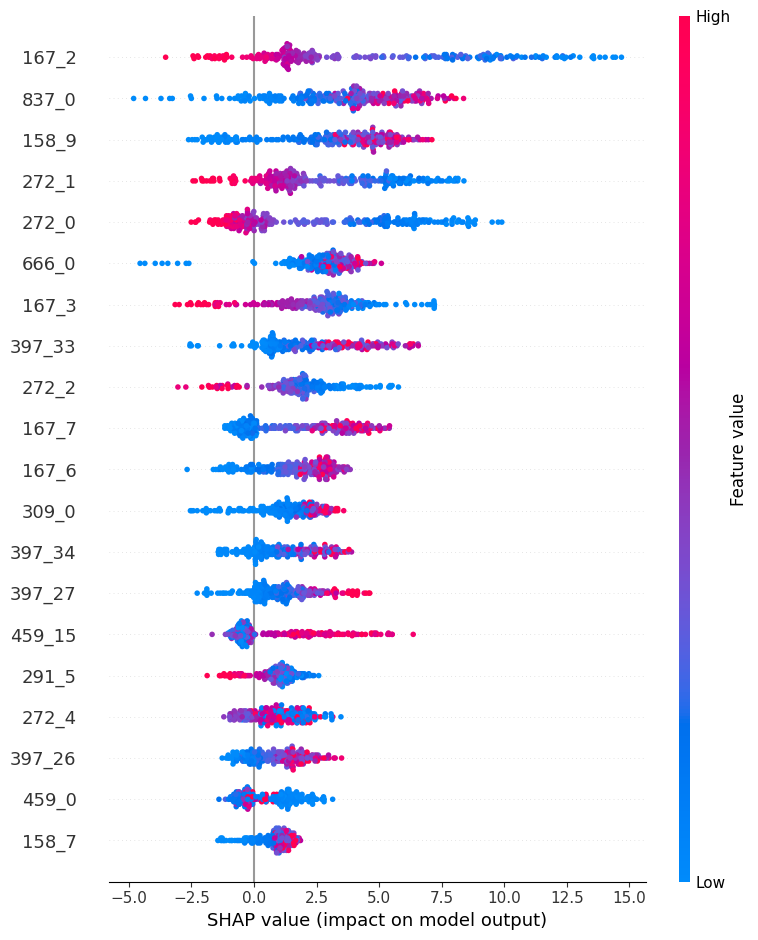

In [105]:
X_risk3 = X_testt[risk_categories == 3]
# Calculate SHAP values
shap_values3 = explainer.shap_values(X_risk3)
shap.summary_plot(shap_values3, X_testt[risk_categories == 3])

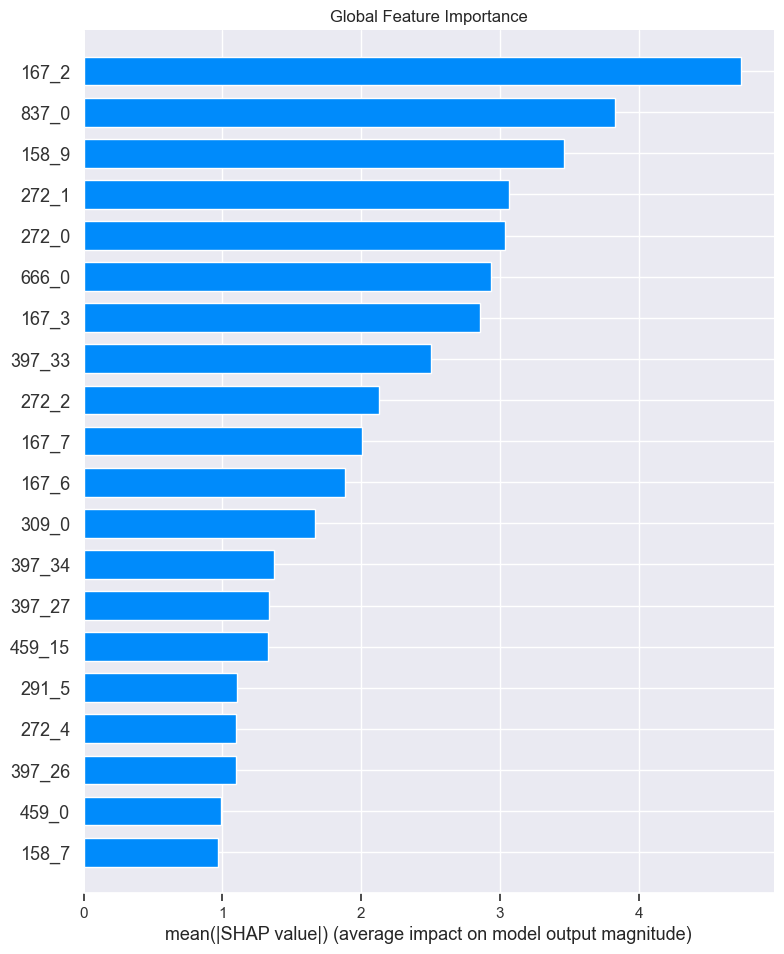

In [125]:
# Plot global feature importance summary plot
shap.summary_plot(shap_values3, X_testt[risk_categories == 3], plot_type='bar', show=False)
plt.title('Global Feature Importance')
plt.show()

Vehicle ID corresponding to choosed index: 23634


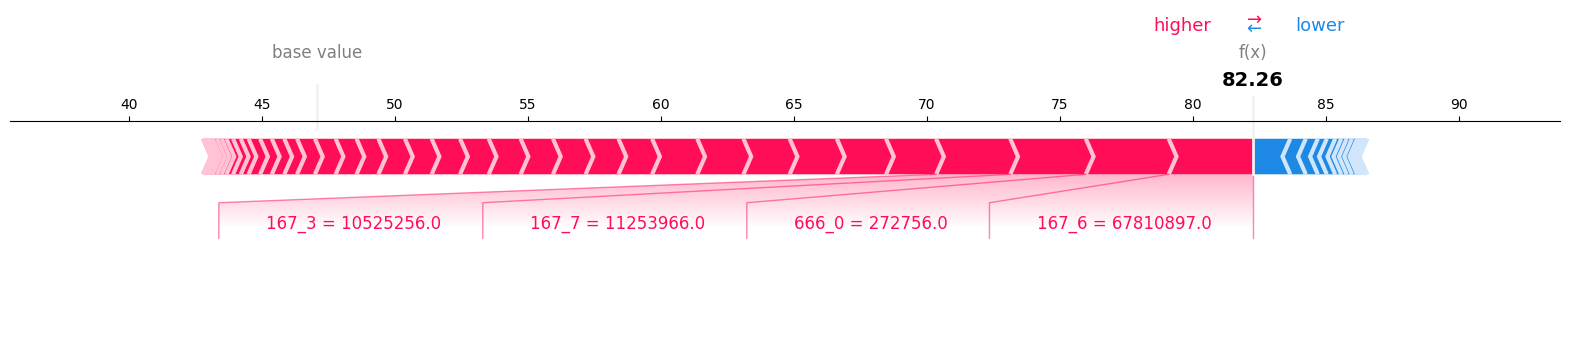

In [112]:
# Choose a specific instance for local explanation (i = 15)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
i = 1
instance_index = np.where(risk_categories == 3)[0][i]  # Find the index of the first instance from the current category
instance = X_testt.iloc[instance_index]  # Get the instance from the test set
    
# Calculate SHAP values for the chosen instance
shap_values_instance = shap_values3[instance_index]

expected_value3 = explainer.expected_value
# Get the Vehicle ID corresponding to the specified index
index_to_lookup = instance.name
vehicle_id = dataset_ffil.loc[index_to_lookup, 'vehicle_id']
print(f"Vehicle ID corresponding to choosed index: {vehicle_id}")


shap.initjs()
# Plot local SHAP force plot for the chosen instance
shap.force_plot(expected_value3, shap_values_instance, instance , matplotlib=True)

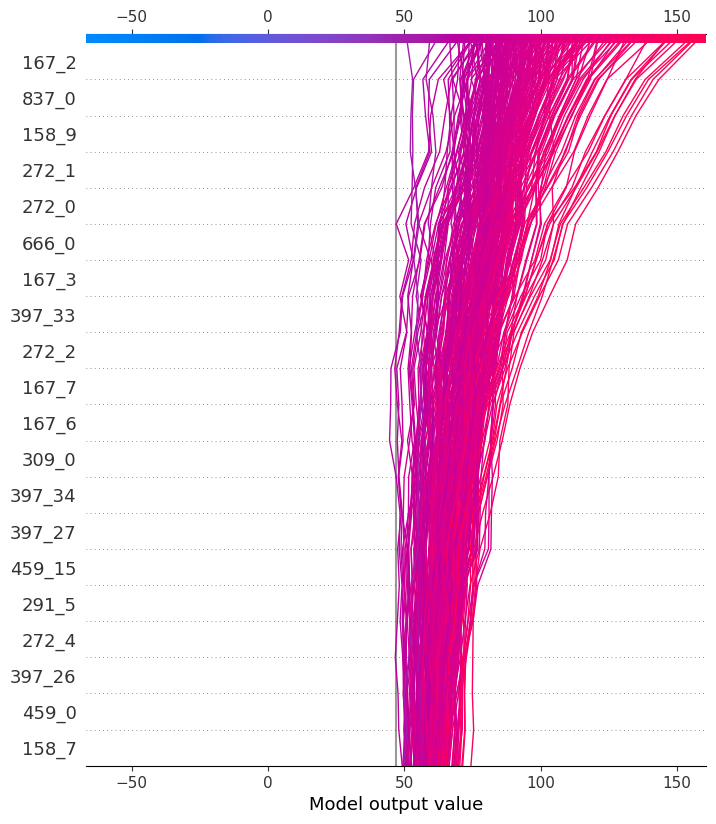

In [108]:
expected_value = explainer.expected_value
X_display= X_testt.columns
shap.decision_plot(expected_value, shap_values3, X_display)

100%|===================| 984/985 [03:52<00:00]        

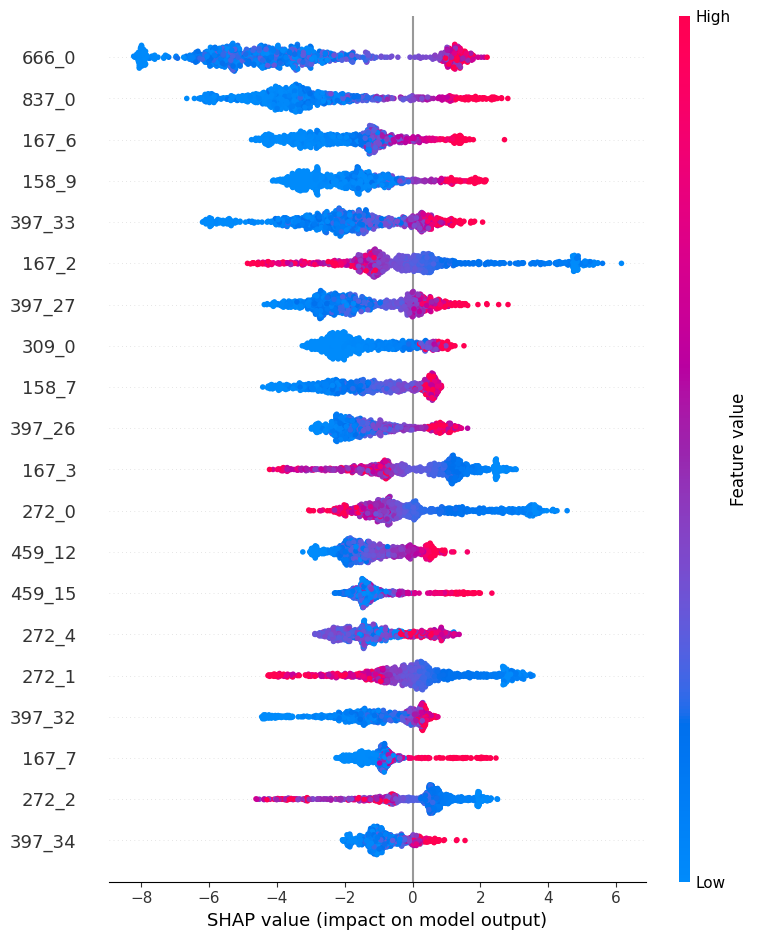

In [106]:
X_risk4 = X_testt[risk_categories == 4]
# Calculate SHAP values
shap_values4 = explainer.shap_values(X_risk4)
shap.summary_plot(shap_values4, X_testt[risk_categories == 4])

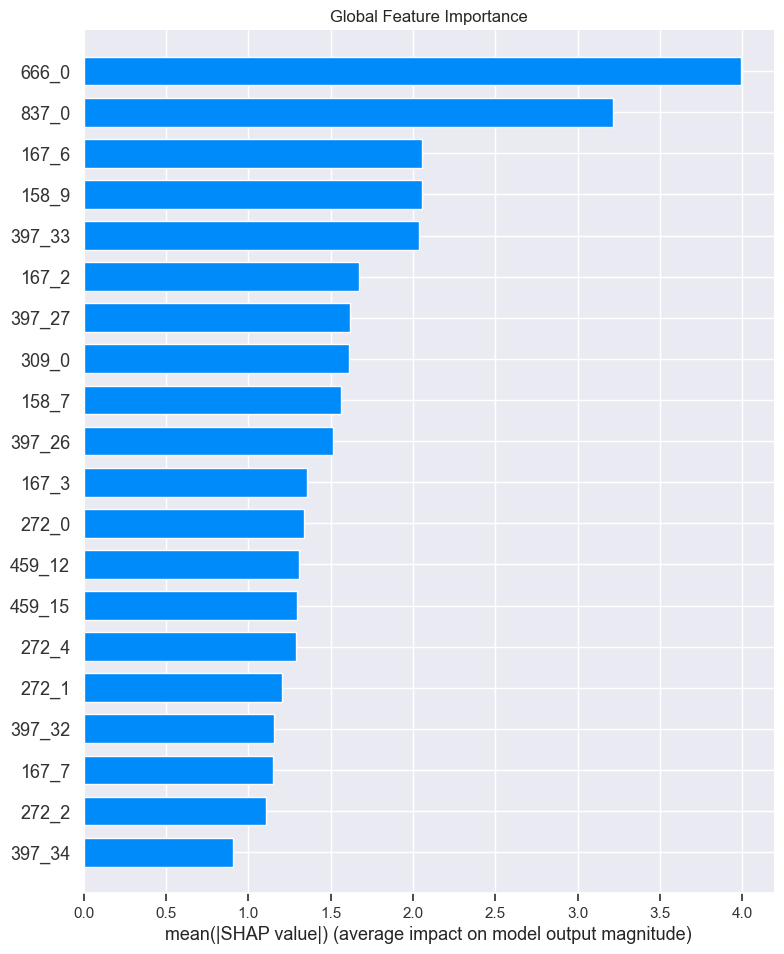

In [126]:
# Plot global feature importance summary plot
shap.summary_plot(shap_values4, X_testt[risk_categories == 4], plot_type='bar', show=False)
plt.title('Global Feature Importance')
plt.show()

Vehicle ID corresponding to choosed index: 5411


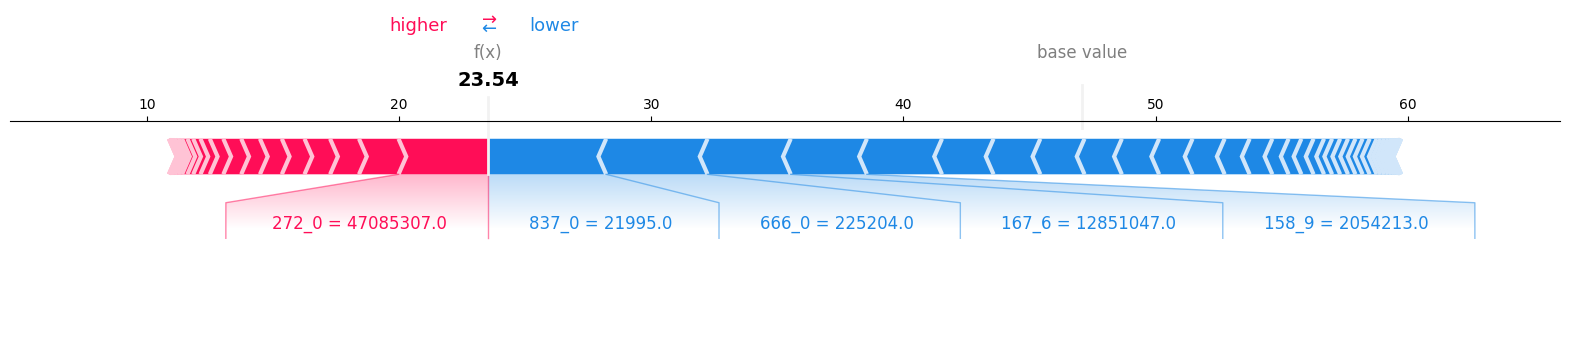

In [113]:
i = 1
instance_index = np.where(risk_categories == 4)[0][i]  # Find the index of the first instance from the current category
instance = X_testt.iloc[instance_index]  # Get the instance from the test set
    
# Calculate SHAP values for the chosen instance
shap_values_instance = shap_values4[instance_index]

expected_value4 = explainer.expected_value
# Get the Vehicle ID corresponding to the specified index
index_to_lookup = instance.name
vehicle_id = dataset_ffil.loc[index_to_lookup, 'vehicle_id']
print(f"Vehicle ID corresponding to choosed index: {vehicle_id}")


shap.initjs()
# Plot local SHAP force plot for the chosen instance
shap.force_plot(expected_value4, shap_values_instance, instance , matplotlib=True)

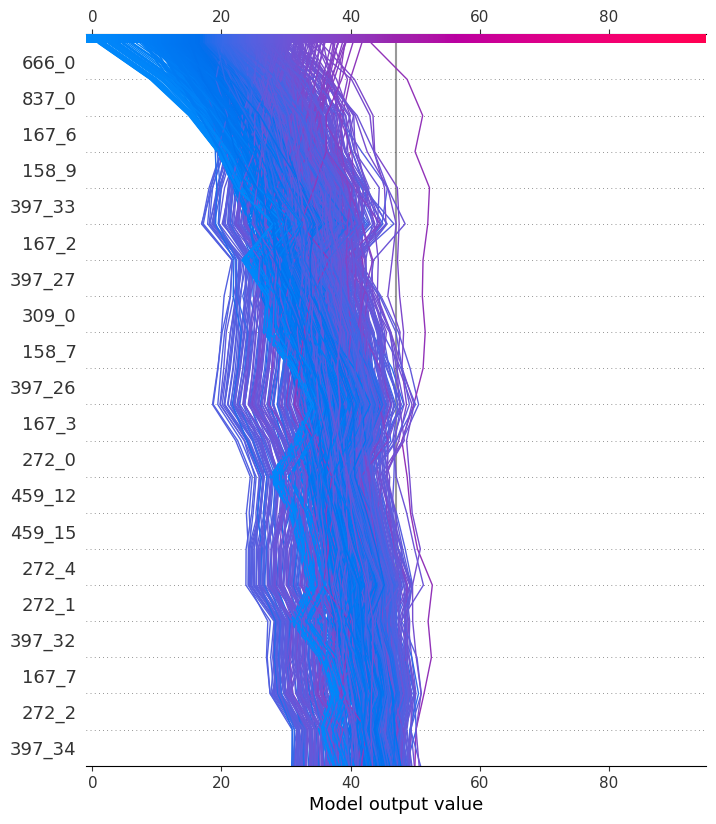

In [109]:
expected_value = explainer.expected_value
X_display= X_testt.columns
shap.decision_plot(expected_value, shap_values4, X_display)